# PD Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [4]:
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
# matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')
import matplotlib_venn
from scipy import stats
import scipy.stats as stats
from sklearn import cross_validation
from collections import Counter

import sklearn
from sklearn import decomposition
from matplotlib import patches as mpatches

/home/jtao/software/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Preprocessing

In [6]:
# file directories
workingDirectory = '/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis/'
genomes = ['hg38','mm10']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath= workingDirectory + '/tag_directories/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'


os.chdir(workingDirectory)

strains = []
treatments = []
owners = []
dates = []
sampleNames = []
for tagDir in os.listdir(tagDirPath):

    metaDataTokens = tagDir.split('_')
    sampleNames.append(tagDir)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip().split('-')[0]
    treatment = metaDataTokens[2].strip()
    owner = metaDataTokens[3].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = '-'.join([x for x in t.split('-')][:-1])
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_sampleNames =[]
# from tagInfo.txt
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []

for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
    rootName = logFile
    for gen in genomes:
        rootName = rootName.replace('.' + gen + '.star.log','')
    totalReads = int(data[5].split()[5])
    uniquelyMappedReads = int(data[8].split()[5])
    multiMappedReads = int(data[23].split()[8])
    unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads

    _sampleNames.append(rootName)
    _totalReads.append(totalReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)
for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']


summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort_index()
summary_frame.to_csv('qc_metrics.tsv', sep='\t', index=False)

In [7]:
clinical_frame = pd.read_csv('clinical_data_17-06-23.txt',sep='\t')
clinical_frame.index = clinical_frame['RNA-seq'].values
clinical_frame = clinical_frame[[x for x in clinical_frame.columns if not 'Unnamed' in x]]

clinical_frame['IL-6'] = [2.0 if x == '<2,0' else float(x) for x in clinical_frame['IL-6']]
clinical_frame['IL-10'] = [5.0 if x == '<5,0' else float(x) for x in clinical_frame['IL-10']]
clinical_frame['CRP'] = [0.0 if x == '<0,2' else float(x) for x in clinical_frame['CRP']]


## Mapping Quality Control

### Plot Distributions of Mapping Statistics

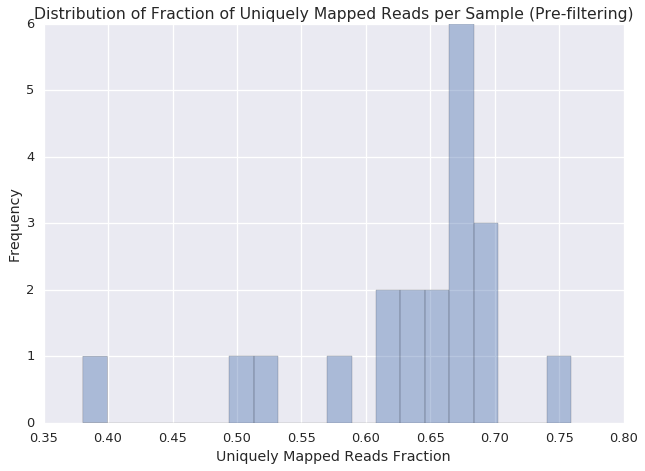

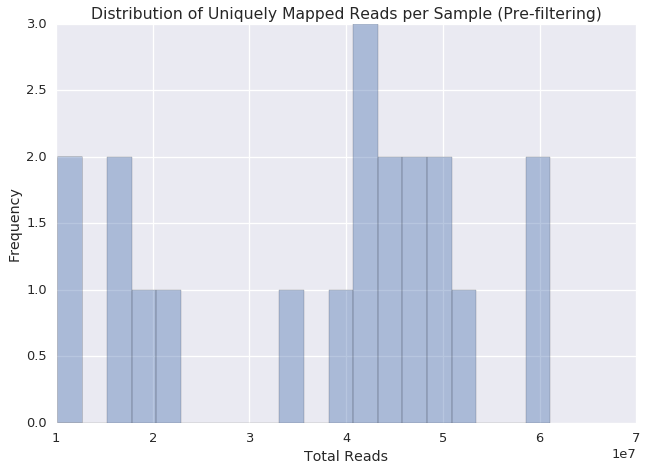

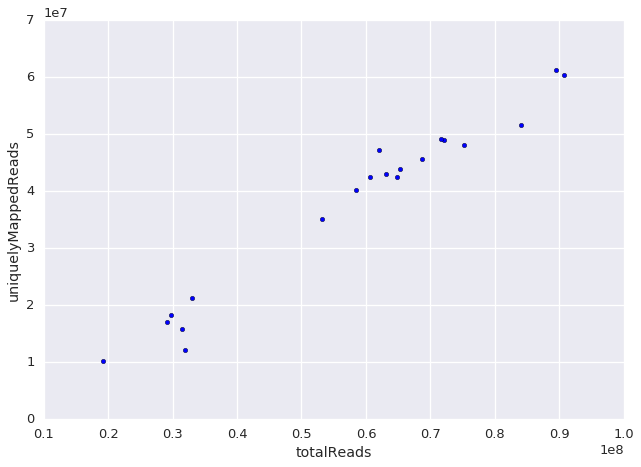

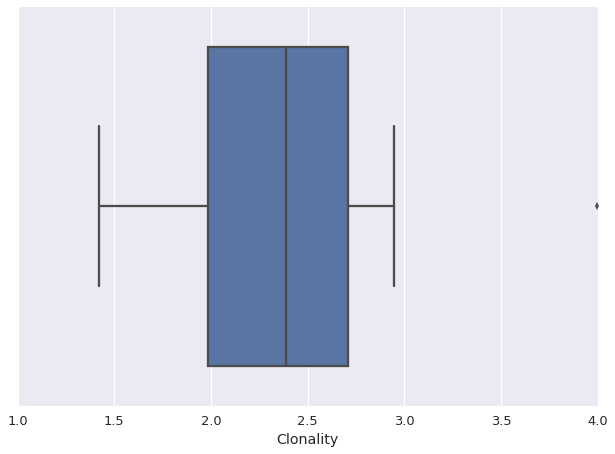

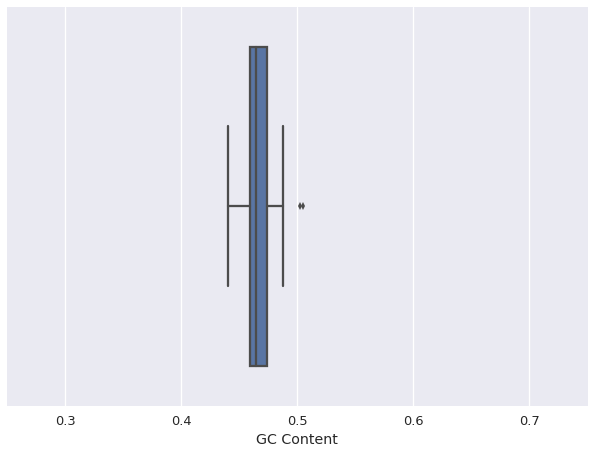

In [8]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()

sns.boxplot(summary_frame['averageTagsPerPosition'].values)
plt.xlabel('Clonality')
plt.show()

sns.boxplot(summary_frame['averageFragmentGCcontent'].values)
plt.xlabel('GC Content')
plt.xlim([0.25,0.75])
plt.show()



### Filter Samples According to Mapping Quality

In [9]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 5000000
pbcThreshold=0.0
gcThreshold=0.10
clonalityThreshold = 4
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

filtered_summary_frame = filtered_summary_frame[np.abs(filtered_summary_frame['averageFragmentGCcontent'] - 0.5) <=gcThreshold]

filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['averageTagsPerPosition'] <= clonalityThreshold]


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

filtered_summary_frame.to_csv('filtered_qc_metrics.tsv', sep='\t', index=False)

Number of Samples: 20
Number of discarded samples: 0
Number of Samples remaining after filtering: 20


### Filter away samples that have advanced PD

In [10]:
advanced_patients = ['PD-13', 'PD-16', 'PD-19', 'Control-26', 'Control-37']
filtered_summary_frame = filtered_summary_frame[~filtered_summary_frame['treatment'].isin(advanced_patients)]
print(filtered_summary_frame.shape)

(20, 18)


### Filter Away patients with long disease duration

In [11]:
long_disease_duration_patients = clinical_frame[clinical_frame['Disease duration'] > 4]['RNA-seq']
filtered_summary_frame = filtered_summary_frame[~filtered_summary_frame['sampleName'].isin(long_disease_duration_patients)]
print(filtered_summary_frame.shape)

(20, 18)


## Calculate Tag Counts and tpm

### Monocytes

#### TPM

In [ ]:
# %%capture
filteredTagDirectories = ' '.join([tagDirPath +x for x in filtered_summary_frame['sampleName']])
tagDirectories = ' '.join([tagDirPath +x for x in summary_frame['sampleName']])
!/bioinformatics/bioinformatics/homer/bin/analyzeRepeats.pl rna hg38 -count exons -condenseGenes -tpm -normMatrix 1e7 -d $filteredTagDirectories >./tpm.tsv

!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -noadj -d $filteredTagDirectories >./raw.tsv

In [166]:
!/bioinformatics/bioinformatics/homer/bin/analyzeRepeats.pl rna hg38 -count exons -condenseGenes -tpm -normMatrix 1e7 -d ./tag_directories_microglia/*/ >./tpm_microglia.tsv




	Tag Directories:
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P10_150819_DGO_15_09_23/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P11_150827_DGO_15_10_30_S70/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P12_151125_DGO_15_12_14/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P14_exvivo_JoS_16_04_27/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P15_160119_DGO_16_04_04/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P16_160125_DGO_16_04_04/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P17_Temporal_160201_DGO_16_04_04/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P18_exvivo_JoS_16_04_27/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P19_Temporal_160426_12cyclesPCR_DGO_16_07_25/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P2_150325_DGO_15_06_15/
		./tag_directories_microglia/Human_Microglia_RNA_PolyA_P21_Cortex_160606_12cyclesPCR_DGO_16_07_25/
		./tag_directories_microglia/Human_Mic

#### RPKM

In [167]:
# %%capture
filteredTagDirectories = ' '.join([tagDirPath +x for x in filtered_summary_frame['sampleName']])
tagDirectories = ' '.join([tagDirPath +x for x in summary_frame['sampleName']])
!/bioinformatics/bioinformatics/homer/bin/analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >./rpkm.tsv

!/bioinformatics/bioinformatics/homer/bin/analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d ./tag_directories_microglia/*/ >./rpkm_microglia.tsv



	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-32_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-44_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-20_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-48_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-30_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-27_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-22_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-34_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-17_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/ana

In [164]:
# !/bioinformatics/bioinformatics/homer/bin/analyzeRepeats.pl rna hg38 -count exons -condenseGenes -tpm -normMatrix 1e7 -d $tagDirectories >./tpm_all.tsv

# all_tpm_frame = pd.read_csv("tpm_all.tsv",sep="\t")
# columns = all_tpm_frame.columns.values
# columns[0] = "refseq"
# for i in range(len(columns)):
#     if "TPM" in columns[i]:
#         columns[i] = columns[i].split("/")[-1].split()[0]
# all_tpm_frame.columns = columns    
# all_tpm_frame['gene'] = [x.split("|")[0] for x in all_tpm_frame['Annotation/Divergence']]
# columns = list(all_tpm_frame.columns.values)
# columns = columns[:-1]
# columns.insert(1,'gene')
# all_tpm_frame = all_tpm_frame[columns]


# ### cluster samples according to correlation
# samples = all_tpm_frame.columns.values[9:]

# labels = ['_'.join(x.split('/')[-1].split('_')[0:3]).replace('Human_RNA_','') for x in columns[9:]]

# spearman_matrix = np.zeros((len(samples), len(samples)))
# pearson_matrix = np.zeros((len(samples), len(samples)))
# for i in range(len(samples)):
#     spearman_matrix[i][i]=1.0
#     pearson_matrix[i][i]=1.0

# for i in range(len(samples) - 1):
#     for j in range(i+1, len(samples)):
#         values_1 = all_tpm_frame[samples[i]].values
#         values_2 = all_tpm_frame[samples[j]].values
#         pearson, pearson_pval = stats.pearsonr(values_1,values_2)
#         spearman, spearman_pval = stats.spearmanr(values_1,values_2)
#         pearson_matrix[i][j] = pearson
#         pearson_matrix[j][i] = pearson
        
#         spearman_matrix[i][j] = spearman
#         spearman_matrix[j][i] = spearman
        
        

# sns.set_context('notebook', font_scale=0.9)
# cg = sns.heatmap(pearson_matrix, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
# # plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.show()

# cg = sns.heatmap(spearman_matrix, xticklabels=labels, yticklabels=labels)
# # plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.show()

# sns.set_context('notebook', font_scale=1.0)

In [165]:
# if not os.path.isdir('scatter_plots'):
#     os.mkdir('scatter_plots')
# treatments = sorted(list(set(summary_frame.index)))
# for i in range(len(treatments)):
#     for j in range(i, len(treatments)):
#         print(treatments[i], treatments[j])
#         columns = sorted(list(set(list(summary_frame.loc[treatments[i],'sampleName']) + 
#                               list(summary_frame.loc[treatments[j],'sampleName']))))
#         data = np.log2(all_tpm_frame.loc[:,columns] + 1)
#         data = data[data.sum(axis=1) > 0.0]
#         data.columns = ['_'.join(x.split('_')[0:3]).replace('Human-HMDM-','').replace('RNA_','') for x in columns]
#         print(data.columns)
#         cg = sns.pairplot(data, 
#                           x_vars=[x for x in data.columns.values if treatments[i][1] in x],
#                           y_vars=[x for x in data.columns.values if treatments[j][1] in x]
#                          )
        
#         plt.savefig('./scatter_plots/' + '_'.join(treatments[i] + treatments[j]) + '_logtpm.png')
#         plt.close()

### Read Monocyte TPM values

In [12]:
threshold = 4
# read in tpm values
tpm_frame = pd.read_csv("tpm.tsv",sep="\t")
columns = tpm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "TPM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
tpm_frame.columns = columns    
tpm_frame['gene'] = [x.split("|")[0] for x in tpm_frame['Annotation/Divergence']]
columns = list(tpm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
tpm_frame = tpm_frame[columns]

refseq_gene_mapping = dict(zip(tpm_frame['refseq'].values, [x.split("|")[0].upper() for x in tpm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0].upper() for x in tpm_frame['Annotation/Divergence']], tpm_frame['refseq'].values))


# get filtered tpm values
filtered_tpm_frame =  tpm_frame[[x for x in tpm_frame.columns if x in filtered_summary_frame['sampleName'].values]]

columns = [x.split('_')[2] for x in filtered_tpm_frame.columns.values]
filtered_tpm_frame.columns = columns
filtered_tpm_frame.index = tpm_frame.gene.values
filtered_tpm_frame = filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >= threshold]

to_write_frame = filtered_tpm_frame.copy()
to_write_frame = to_write_frame[to_write_frame.max(axis=1) >= threshold]
# to_write_frame.index = [refseq_gene_mapping[x] for x in to_write_frame.index.values]
to_write_frame.to_csv('filtered_tpm.tsv', sep='\t')

# create frame that's easier to use with factor plots
pivoting_frame = filtered_tpm_frame.transpose()
_refseq = []
_gene = []
_tpm = []
_max_tpm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for gene in pivoting_frame.columns:
    refseq = gene_refseq_mapping[gene.upper()]
    gene_tpms = pivoting_frame[gene].values
    tpm_med = np.max(gene_tpms)
    for tpm in gene_tpms:
        _tpm.append(tpm)
        _refseq.append(refseq)
        _gene.append(gene)
        _max_tpm.append(tpm_med)
filtered_tpm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'tpm': _tpm,
'max tpm':_max_tpm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        

### Read microglia TPM values

In [50]:
threshold = 4
# read in tpm_microglia values
tpm_microglia_frame = pd.read_csv("tpm_microglia.tsv",sep="\t")

columns = tpm_microglia_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "TPM" in columns[i]:
        columns[i] = columns[i].split("/")[-2]
tpm_microglia_frame.columns = columns    
tpm_microglia_frame['gene'] = [x.split("|")[0] for x in tpm_microglia_frame['Annotation/Divergence']]
columns = list(tpm_microglia_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
tpm_microglia_frame = tpm_microglia_frame[columns]

filtered_tpm_microglia_frame = tpm_microglia_frame[[x for x in tpm_microglia_frame.columns if 'PolyA' in x]]
columns = [x.split('_')[4] for x in filtered_tpm_microglia_frame.columns.values]
filtered_tpm_microglia_frame.columns = columns
filtered_tpm_microglia_frame.index = tpm_microglia_frame.gene.values
filtered_tpm_microglia_frame = filtered_tpm_microglia_frame[filtered_tpm_microglia_frame.index.isin(filtered_tpm_frame.index)]

# create frame that's easier to use with factor plots
pivoting_frame = filtered_tpm_microglia_frame.transpose()
_refseq = []
_gene = []
_tpm_microglia = []
_max_tpm_microglia = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = (['Microglia'] * filtered_tpm_microglia_frame.shape[1]) * pivoting_frame.shape[1]
for gene in pivoting_frame.columns:
    refseq = gene_refseq_mapping[gene.upper()]
    gene_tpm_microglias = pivoting_frame[gene].values
    tpm_microglia_med = np.max(gene_tpm_microglias)
    for tpm_microglia in gene_tpm_microglias:
        _tpm_microglia.append(tpm_microglia)
        _refseq.append(refseq)
        _gene.append(gene)
        _max_tpm_microglia.append(tpm_microglia_med)
filtered_tpm_microglia_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'tpm': _tpm_microglia,
'max tpm':_max_tpm_microglia,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame


## Variance Analysis

In [13]:
pd_cols = [x for x in filtered_tpm_frame.columns if 'PD' in x]

control_cols = [x for x in filtered_tpm_frame.columns if not 'PD' in x]

In [14]:
def calc_mad(vals):
    med = np.median(vals)
    abs_devs = [abs(x - med) for x in vals]
    mad = np.median(abs_devs)
    return mad

In [15]:
pd_mads = filtered_tpm_frame[pd_cols].apply(calc_mad,axis=1)

control_mads = filtered_tpm_frame[control_cols].apply(calc_mad,axis=1)

pd_vars = filtered_tpm_frame[pd_cols].var(axis=1)

control_vars = filtered_tpm_frame[control_cols].var(axis=1)




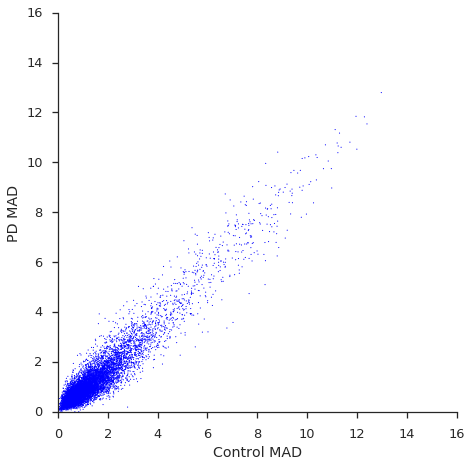

In [16]:
sns.set_style('ticks')
control_mads_log = np.log2(control_mads+1)
pd_mads_log = np.log2(pd_mads + 1)

plt.scatter(control_mads_log, 
            pd_mads_log, 
            marker = '.', edgecolors='None', s=5)
plt.xlabel('Control MAD')
plt.ylabel('PD MAD')

gene_names = filtered_tpm_frame.index.values
tuples = zip(control_mads_log, pd_mads_log, gene_names)

# for x, y, label in tuples:
#     fold = x/y
#     if (fold >= 4 or fold <=1/4) and (x>=2 or y>=2) :
#         plt.annotate(label, size=8, xy=(x,y))
#         print(label)
plt.xlim(0,16)
plt.ylim(0,16)
ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
sns.despine()

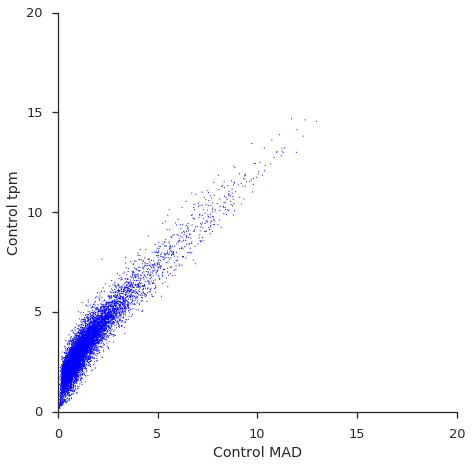

In [17]:
tpms = filtered_tpm_frame[control_cols].mean(axis=1)
plt.scatter(np.log2(control_mads+1), 
            np.log2(tpms+1), marker = '.', edgecolors='None', s=5)
plt.xlabel('Control MAD')
plt.ylabel('Control tpm')
plt.xlim([0,20])
plt.ylim([0,20])

ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
sns.despine()
plt.savefig('./figures/tpm_mad_scatterplot_control.pdf',bbox_inches='tight')

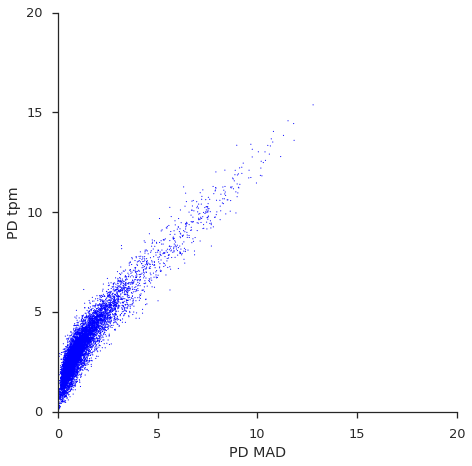

In [18]:
tpms = filtered_tpm_frame[pd_cols].mean(axis=1)
plt.scatter(np.log2(pd_mads+1), 
            np.log2(tpms+1), marker = '.', edgecolors='None', s=5)
plt.xlabel('PD MAD')
plt.ylabel('PD tpm')
plt.xlim([0,20])
plt.ylim([0,20])


ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
sns.despine()
plt.savefig('./figures/tpm_mad_scatterplot_pd.pdf',bbox_inches='tight')

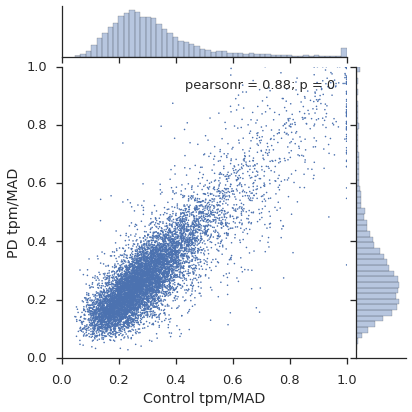

In [19]:
pd_tpms = filtered_tpm_frame[pd_cols].median(axis=1)
control_tpms = filtered_tpm_frame[control_cols].median(axis=1)
pd_ratios = (pd_mads +1) / (pd_tpms+1)
control_ratios = (control_mads +1) / (control_tpms+1)

jg = sns.jointplot(control_ratios,
            pd_ratios, 
            xlim=(0,1),
            ylim=(0,1),
            marker = '.', edgecolors='None', s=10)

jg.ax_joint.set_xlabel('Control tpm/MAD')

jg.ax_joint.set_ylabel('PD tpm/MAD')
sns.despine()
plt.savefig('./figures/tpm_mad_rr_plot.pdf',bbox_inches='tight')

## Calcuate Differential Expression with EdgeR

In [32]:
# %%capture
raw_frame = pd.read_csv('./raw.tsv', sep='\t')


In [33]:
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['sampleName'], filtered_summary_frame['simpleTreatment']))
samples = [x.split('/')[-1].split()[0] for x in raw_frame.columns[8:].values]

conditions = " ".join([sample_condition_dict[x] for x in samples])
!getDiffExpression.pl raw.tsv $conditions > homer_diffExpresion.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-regulated in PD vs. Control: 2 (0.008%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PD vs. Control: 35 (0.132%) [log2fold<-1, FDR<0.05]



In [35]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [39]:
samples = sorted(set(raw_frame.columns.values[8:]))

labels = ['PD' if 'PD' in x else 'Control' for x in raw_frame.columns.values[8:]]
run_excluded_dict = {} #{run:[excludedSamples]}

skf = cross_validation.StratifiedKFold(labels, 5, shuffle=True)
runNumber = 0
numExcluded = 4
for test_indices, exclude_indices in skf:
    runNumber += 1

    # get samples to use
    test_samples = [samples[i] for i in test_indices]
    excluded_samples = [samples[i] for i in exclude_indices]
    run_excluded_dict[runNumber] = excluded_samples
    # create raw.tsv for current cross-validation set
    current_raw_frame = raw_frame[list(raw_frame.columns.values[:8]) + test_samples]
    columns = current_raw_frame.columns.values
#     columns[0] = 'Transcript/RepeatID (cmd=' + ' '.join(test_samples) + ')'
    current_raw_frame.columns = columns
    current_raw_path = 'raw_' + str(runNumber) + '.tsv'
    current_raw_frame.to_csv(current_raw_path, index=False, sep='\t')
    conditions = " ".join([x.split('/')[-1].split('_')[2].split('-')[0] for x in test_samples])
    
#     # call EdgeR
    current_diffExpression_path = 'homer_diffExpression_' + str(runNumber) + '.tsv'
    ! getDiffExpression.pl $current_raw_path $conditions > $current_diffExpression_path
    


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-regulated in PD vs. Control: 16 (0.060%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PD vs. Control: 94 (0.354%) [log2fold<-1, FDR<0.05]


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-regulated in PD vs. Control: 1 (0.004%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PD vs. Control: 29 (0.109%) [log2fold<-1, FDR<0.05]


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up

In [40]:
run_genes_dict = {} # {excludedSamples:{significantGenes}}
run_genes_dict['All Patients'] = set(diffExpression_frame[diffExpression_frame['Control vs. PD adj. p-value'] <0.05]['gene'].values)

significant_genes_intersection = None
significant_genes_union = set()

for i in range(1,6):
    # read current differentially expressed gene output
    current_path = 'homer_diffExpression_' + str(i) + '.tsv'
    current_diffExpression_frame = pd.read_csv(current_path, sep='\t')
    columns = current_diffExpression_frame.columns.values
    columns[0]='refseq'
    columns = [x.split('/')[-1] if '/' in x else x for x in columns]
    current_diffExpression_frame.columns=columns
    current_diffExpression_frame.index = current_diffExpression_frame.refseq.values
    current_diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in current_diffExpression_frame['Divergence']]
    columns = ['refseq', 'gene'] + [x for x in current_diffExpression_frame.columns if 'vs.' in x]
    current_diffExpression_frame = current_diffExpression_frame[columns]
    
    significant_genes = set(current_diffExpression_frame[current_diffExpression_frame['Control vs. PD adj. p-value'] <0.05]['gene'].values)

    print(len(significant_genes))    
    run_genes_dict[str(i)]  = significant_genes
    if significant_genes_intersection == None:

        significant_genes_intersection  = significant_genes
    else:
        significant_genes_intersection = significant_genes_intersection.intersection(significant_genes)
    significant_genes_union = significant_genes_union.union(significant_genes)

158
33
3
5
18


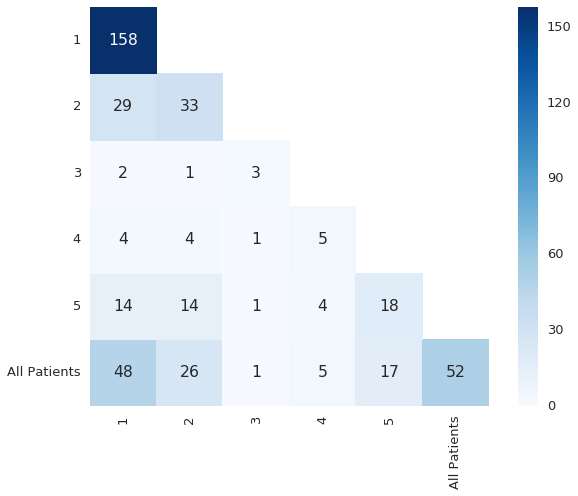

In [41]:
sorted_keys = sorted(run_genes_dict.keys())
matrix = np.zeros((6,6))
for i in range(matrix.shape[0] - 1):
    key_1 = sorted_keys[i]
    genes_1 = run_genes_dict[key_1]
    matrix[i][i] = len(genes_1)
    for j in range(i + 1, matrix.shape[0]):
        key_2 = sorted_keys[j]
        genes_2 = run_genes_dict[key_2]
        intersection = genes_1.intersection(genes_2)
        matrix[j][i] = len(intersection)
matrix[5][5] = len(run_genes_dict['All Patients'])
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
for i in range(6):
    mask[i][i]=False
with sns.axes_style("white"):
    sns.heatmap(matrix, 
                mask=mask,
                xticklabels= sorted_keys,
                yticklabels = sorted_keys,
                cmap='Blues',
                fmt='g',
                annot=True,
                square=True)
    plt.yticks(rotation=0)  
    plt.xticks(rotation=90)  
    plt.savefig('./figures/cross_validation_overlap.pdf',bbox_inches='tight')

## Statistical Testing

### Test Difference in Variation and Difference in Medians

In [42]:
variability_pvals = []
median_pvals = []
genes = []
control_medians = []
pd_medians = []
up_or_downs = []
for refseq in set(filtered_tpm_plottingFrame['refseq'].values):

    gene = refseq_gene_mapping[refseq]
    currentVals = filtered_tpm_plottingFrame[filtered_tpm_plottingFrame['refseq'] == refseq]
    
    control_tpms = currentVals[currentVals['treatment'] == 'Control']['tpm'].values
    pd_tpms = currentVals[currentVals['treatment'] == 'PD']['tpm'].values

    control_med = np.median(control_tpms)
    pd_med = np.median(pd_tpms)

    control_medians.append(control_med)
    pd_medians.append(pd_med)
    
    control_distances = [abs(x - control_med) for x in control_tpms]
    pd_distances = [abs(x - pd_med) for x in pd_tpms]

    ks_stat, p_ks_variability = stats.ks_2samp(control_distances, pd_distances)
    ks_stat, p_ks_median = stats.ks_2samp(control_tpms, pd_tpms)
    
    variability_pvals.append(p_ks_variability)
    median_pvals.append(p_ks_median)
    
    if pd_med >= control_med:
        up_or_downs.append('up')
    else:
        up_or_downs.append('down')

    genes.append(gene)
gene_edgerp_dict = dict(zip(diffExpression_frame['gene'], diffExpression_frame['Control vs. PD adj. p-value'].values))
edger_pvals = [gene_edgerp_dict[x] if x in gene_edgerp_dict else 1.0 for x in genes]

pval_frame = pd.DataFrame({'Gene':genes, 
                           'variability p-value':variability_pvals,
                           'median p-value':median_pvals,
                           'Control Median':control_medians,
                           'PD Median':pd_medians, 
                           'EdgeR p-value':edger_pvals,
                           'Up or Down':up_or_downs
                          })
            

#### Disregulated Genes

In [52]:
disregulated_genes = pval_frame[(pval_frame['median p-value'] > 0.01) & 
                                (pval_frame['variability p-value'] < 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >=4].index.values))
                               ]['Gene']


In [53]:
pd_cols = [x for x in filtered_tpm_frame.columns if 'PD' in x]

control_cols = [x for x in filtered_tpm_frame.columns if not 'PD' in x]

In [54]:
pd_mads = filtered_tpm_frame[pd_cols].apply(calc_mad,axis=1)

control_mads = filtered_tpm_frame[control_cols].apply(calc_mad,axis=1)

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


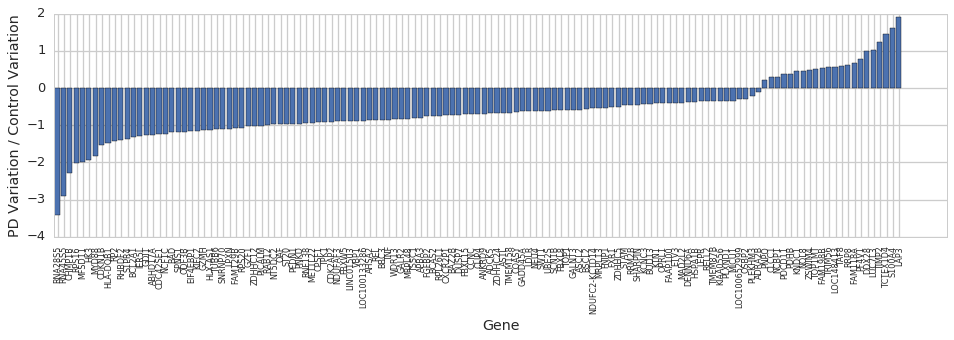

In [55]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16,4))
    disregulated_genes_toplot = [x for x in disregulated_genes if not 'SNOR' in x and not 'MIR' in x]
    ratios = (pd_mads.ix[disregulated_genes_toplot]+1)/(control_mads.ix[disregulated_genes_toplot]+1)
    ratios.sort_values(inplace=True)
    plt.bar(range(len(ratios)), list(np.log2(ratios)))
    plt.xticks(np.arange(0.5, len(ratios)), ratios.index.values, rotation=90, size=8);
    plt.xlabel('Gene')
    plt.ylabel('PD Variation / Control Variation')
    plt.savefig('./figures/disregulated_genes_ratio_barplot.pdf', bbox_inches='tight')

#### Differentially Expressed

In [58]:
threshold = 10
diff_expressed_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >=threshold].index.values)) 
                               ]['Gene']
downregulated_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >=threshold].index.values)) &
                                (pval_frame['Up or Down'] == 'down')
                               ]['Gene']
upregulated_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >=threshold].index.values))  &
                                (pval_frame['Up or Down'] == 'up')
                               ]['Gene']
print(len(diff_expressed_genes))
print('**Down**', len(downregulated_genes))
for g in sorted(downregulated_genes):
    print(g)
print('**UP**', len(upregulated_genes))
for g in sorted(upregulated_genes):
    print(g)
print('**DIS**', len(disregulated_genes))
for g in sorted(disregulated_genes):
    print(g)

76
**Down** 49
AMDHD2
ATF4
DNASE2
FAM20C
GADD45B
GLTPD2
GSDMD
HAGH
ITGAL
LOC200772
LOC728392
MFF
MIR1229
MIR2861
MIR6087
NCF1
PIM3
PQBP1
PRDX2
RAB1B
RAB4B
RPS14
RPS4X
SIAH2
SNHG15
SNHG19
SNORA17A
SNORD11B
SNORD13
SNORD135
SNORD136
SNORD18C
SNORD1C
SNORD2
SNORD29
SNORD32A
SNORD43
SNORD55
SNORD59B
SNORD64
SNORD69
SNORD71
SNORD73A
SNORD74
SNORD95
SREBF1
TMEM104
TOMM7
UBXN11
**UP** 27
CPPED1
HIST1H1C
HIST1H2AC
LMNB1
MIR1248
MTIF3
NDUFC1
RNU4-2
RPL32
SCARNA11
SCARNA16
SCARNA8
SGMS2
SNORA1
SNORA10
SNORA14A
SNORA21
SNORA28
SNORA4
SNORA46
SNORA5A
SNORA62
SNORA74A
SNORA81
SNORD22
SNORD93
USMG5
**DIS** 165
ABHD17A
ADCK5
ADRA2B
AHSA2
ANKRD9
APBA3
ASCL2
ASTL
BAD
BAZ2B
BBC3
BCAS2
BCL2A1
BSCL2
BUD13
CCNC
CDC42SE1
CDK2AP2
CDKN1B
CHMP1B
CLCC1
CLIP4
COASY
CPSF1
CXCR2P1
DDX28
DENND6A
DUSP7
EIF4EBP1
ETV3
FAAP100
FAM118A
FAM129B
FAM198B
FBXL15
FBXL8
FBXW5
FGFBP2
FNIP1
FXR1
GADD45A
GALNT3
GALR2
GDI1
GZF1
GZMH
HK3
HLA-DQB1
HLX-AS1
HSPA1B
IER5L
KCNC3
KIAA0556
KIFC2
KNDC1
KTN1
LAP3
LDLR
LEPR
LINC01503
LOC1001

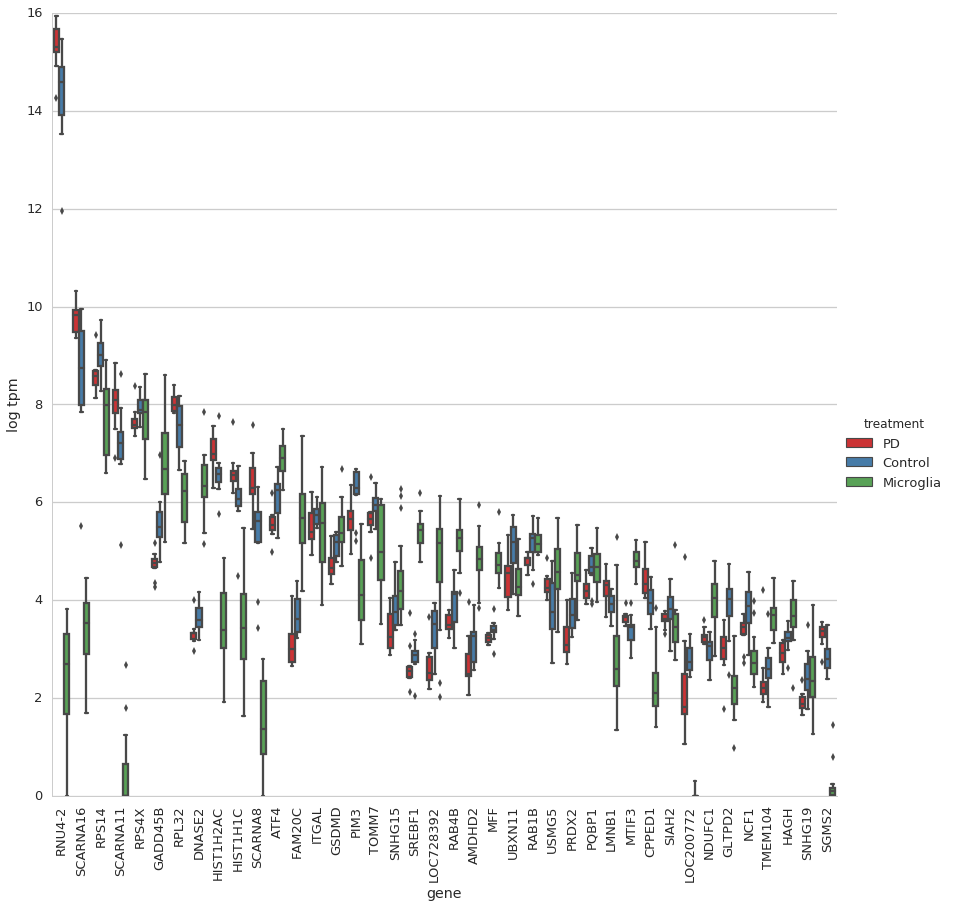

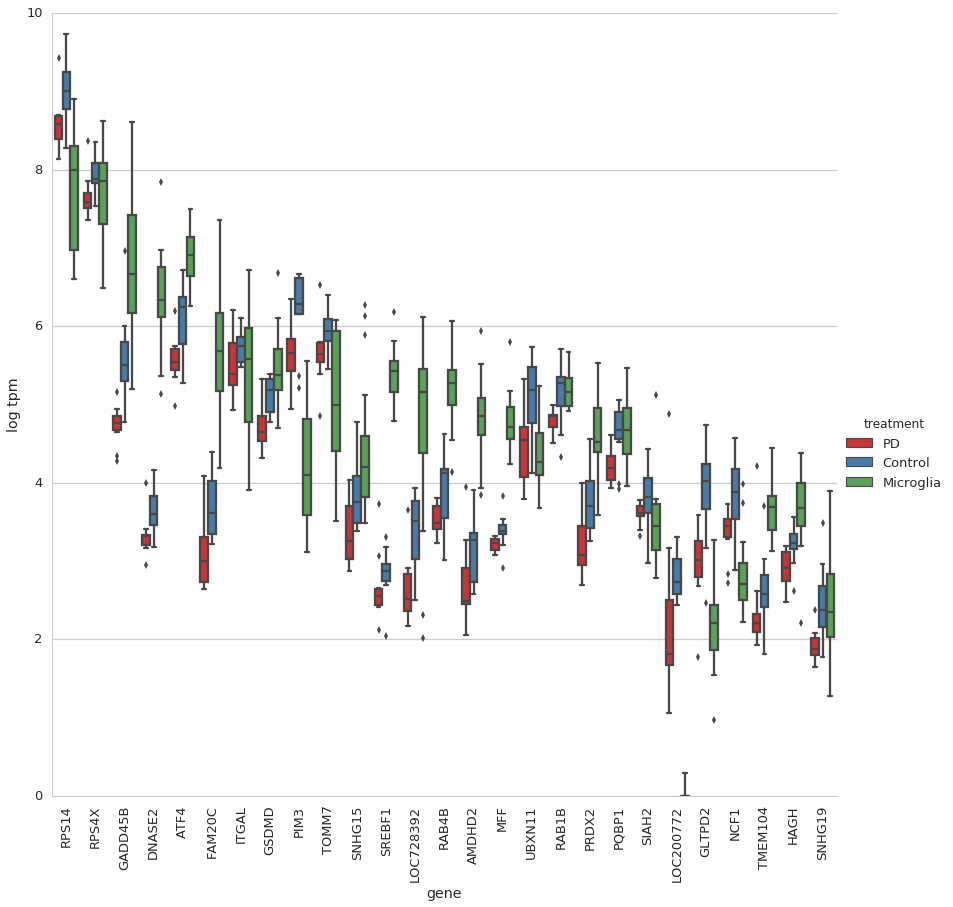

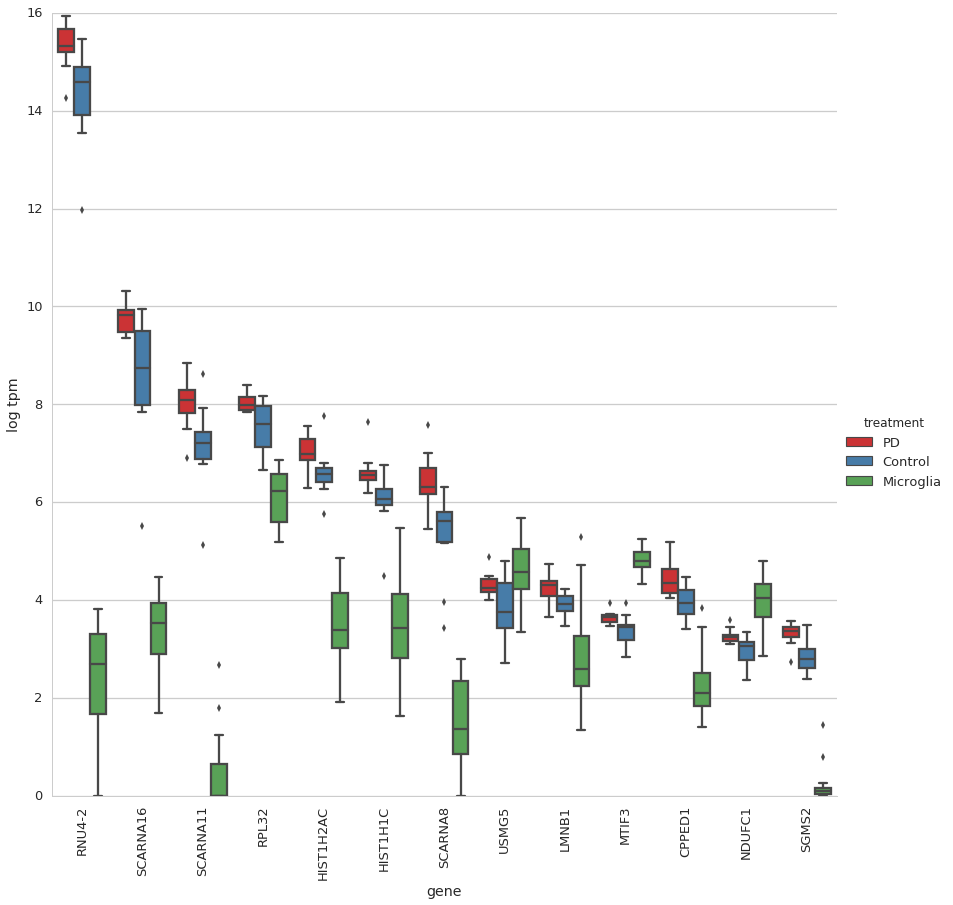

In [59]:
with sns.axes_style('whitegrid'):
    data = pd.concat([filtered_tpm_plottingFrame[filtered_tpm_plottingFrame['gene'].isin(diff_expressed_genes)],
                      filtered_tpm_microglia_plottingFrame[filtered_tpm_microglia_plottingFrame['gene'].isin(diff_expressed_genes)]
                      ])
    data = data[~data['gene'].str.contains('SNOR')]
    data = data[~data['gene'].str.contains('MIR')]
    data['log tpm'] = np.log2(data['tpm'] + 1)
    data.sort_values(['max tpm', 'gene'], ascending=False, inplace=True)

    sns.factorplot(data = data, 
                   x='gene', 
                   y = 'log tpm', 
                   hue='treatment', 
                   kind='box', 
                   size=12,
                   palette='Set1',
                   order = data['gene'].unique(),
                   hue_order = ['PD', 'Control', 'Microglia']
                  )
    plt.xticks(rotation=90)
    plt.savefig('./figures/diff_expressed_genes_boxplot.pdf', bbox_inches='tight')

    data = pd.concat([filtered_tpm_plottingFrame[filtered_tpm_plottingFrame['gene'].isin(downregulated_genes)],
                      filtered_tpm_microglia_plottingFrame[filtered_tpm_microglia_plottingFrame['gene'].isin(downregulated_genes)]
                      ])
    data = data[~data['gene'].str.contains('SNOR')]
    data = data[~data['gene'].str.contains('MIR')]
    data['log tpm'] = np.log2(data['tpm'] + 1)
    data.sort_values(['max tpm', 'gene'], ascending=False, inplace=True)

    sns.factorplot(data = data, 
                   x='gene', 
                   y = 'log tpm', 
                   hue='treatment', 
                   kind='box', 
                   size=12,
                   palette='Set1',
                   order = data['gene'].unique(),
                   hue_order = ['PD', 'Control', 'Microglia']
                  )
    plt.xticks(rotation=90)
    plt.savefig('./figures/down_regulated_genes_boxplot.pdf', bbox_inches='tight')

    data = pd.concat([filtered_tpm_plottingFrame[filtered_tpm_plottingFrame['gene'].isin(upregulated_genes)],
                      filtered_tpm_microglia_plottingFrame[filtered_tpm_microglia_plottingFrame['gene'].isin(upregulated_genes)]
                      ])
    data = data[~data['gene'].str.contains('SNOR')]
    data = data[~data['gene'].str.contains('MIR')]
    data['log tpm'] = np.log2(data['tpm'] + 1)
    data.sort_values(['max tpm', 'gene'], ascending=False, inplace=True)

    sns.factorplot(data = data, 
                   x='gene', 
                   y = 'log tpm', 
                   hue='treatment', 
                   kind='box', 
                   size=12,
                   palette='Set1',
                   order = data['gene'].unique(),
                   hue_order = ['PD', 'Control', 'Microglia']
                  )
    plt.xticks(rotation=90)
    plt.savefig('./figures/up_regulated_genes_boxplot.pdf', bbox_inches='tight')


## Cross Validation

In [61]:
# idr_genes = set(idr_tpm_frame.index.values)
all_genes = set(tpm_frame['gene'].values)
tested_genes = pval_frame['Gene'].values
samples = sorted(set(filtered_tpm_plottingFrame['simplifiedName'].values))
treatments = [x.split('-')[0] for x in samples]
labels = treatments

refseqs = []
median_pvals = []
variability_pvals = []
genes = []
up_down = []
run = []

skf = cross_validation.StratifiedKFold(labels, 5, shuffle=True)
runNumber = 0
for test_indices, exclude_indices in skf:
    runNumber += 1
    print(runNumber)
    test_samples = [samples[i] for i in test_indices]
    excluded_samples = [samples[i] for i in exclude_indices]
    current_frame = filtered_tpm_plottingFrame[filtered_tpm_plottingFrame['simplifiedName'].isin(
        test_samples)]
    print("%s %s" % (test_indices, exclude_indices))
    print("%s %s" % (test_samples, excluded_samples))
    

    for refseq in set(current_frame['refseq'].values):
        gene = refseq_gene_mapping[refseq]
        if gene in all_genes:
            run.append(runNumber)
            currentVals = current_frame[current_frame['refseq'] == refseq]

            control_vals = currentVals[currentVals['treatment'] == 'Control']['tpm'].values
            pd_vals = currentVals[currentVals['treatment'] == 'PD']['tpm'].values
            
            ks_stat, p_median = stats.ks_2samp(control_vals, pd_vals)

            control_med = np.median(control_vals)
            pd_med = np.median(pd_vals)
            control_distances = [abs(x - control_med) for x in control_vals]
            pd_distances = [abs(x - pd_med) for x in pd_vals]

            ks_stat, p_variability = stats.ks_2samp(control_distances, pd_distances)
            
            variability_pvals.append(p_variability)
            median_pvals.append(p_median)
            genes.append(gene)
            refseqs.append(refseq)

            if np.mean(control_vals) < np.mean(pd_vals):
                up_down.append('up')
            else:
                up_down.append('down')
        
gene_edgerp_dict = dict(zip(diffExpression_frame['gene'], diffExpression_frame['Control vs. PD adj. p-value'].values))
edger_pvals = [gene_edgerp_dict[x] if x in gene_edgerp_dict else 1.0 for x in genes]
cv_frame = pd.DataFrame({'gene':genes,
                            'refseq':refseqs,
                            'median p-value':median_pvals,
                            'variability p-value': variability_pvals,
                            'EdgeR p-value':edger_pvals,
                            'Up or Down':up_down,
                            'Run':run
                           }) 

1
[ 0  1  2  3  5  6  7  9 10 11 12 14 16 17 18 19] [ 4  8 13 15]
['Control-17', 'Control-20', 'Control-22', 'Control-27', 'Control-32', 'Control-34', 'Control-44', 'Control-49', 'PD-07', 'PD-08', 'PD-09', 'PD-11', 'PD-14', 'PD-15', 'PD-21', 'PD-23'] ['Control-30', 'Control-48', 'PD-10', 'PD-12']
2
[ 0  2  3  4  6  7  8  9 10 12 13 14 15 17 18 19] [ 1  5 11 16]
['Control-17', 'Control-22', 'Control-27', 'Control-30', 'Control-34', 'Control-44', 'Control-48', 'Control-49', 'PD-07', 'PD-09', 'PD-10', 'PD-11', 'PD-12', 'PD-15', 'PD-21', 'PD-23'] ['Control-20', 'Control-32', 'PD-08', 'PD-14']
3
[ 0  1  3  4  5  6  7  8 10 11 12 13 14 15 16 17] [ 2  9 18 19]
['Control-17', 'Control-20', 'Control-27', 'Control-30', 'Control-32', 'Control-34', 'Control-44', 'Control-48', 'PD-07', 'PD-08', 'PD-09', 'PD-10', 'PD-11', 'PD-12', 'PD-14', 'PD-15'] ['Control-22', 'Control-49', 'PD-21', 'PD-23']
4
[ 0  1  2  4  5  6  8  9 10 11 13 14 15 16 18 19] [ 3  7 12 17]
['Control-17', 'Control-20', 'Control-22

#### Diff expressed KS

In [75]:
diff_expressed_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']

print(len(diff_expressed_genes))
p_threshold = 0.05
cv_genes = []
for gene in sorted(diff_expressed_genes):
    if gene in all_genes:
        pvals = cv_frame[cv_frame['gene'] == gene]['median p-value'].values
        max_pval = np.max(pvals)
        mean_pval = np.mean(pvals)
        if max_pval < p_threshold:
#             print(gene, mean_pval, max_pval)
            cv_genes.append(gene)
#             print(gene)
print(len(cv_genes))

110
110


#### Disregulated

In [38]:
disregulated_genes = pval_frame[(pval_frame['median p-value'] > 0.01) & 
                                (pval_frame['variability p-value'] < 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
p_threshold = 0.1
print(len(disregulated_genes))
cv_disregulated_genes = []
for gene in disregulated_genes:
    if gene in all_genes:
        pvals = cv_frame[cv_frame['gene'] == gene]['variability p-value'].values
        max_pval = np.max(pvals)
        mean_pval = np.mean(pvals)
        mode_pval = scipy.stats.mode(pvals)[0][0]
        if mode_pval < p_threshold:
            print(gene, mean_pval, max_pval, )
            cv_disregulated_genes.append(gene)
print(len(cv_disregulated_genes))

101
MFSD11 0.0221319988396 0.0496543685867
DUSP7 0.346978057612 0.928954777402
ABHD17A 0.0240541576614 0.0496543685867
RHBDF2 0.377441758549 0.928954777402
SNORD123 0.407605881422 0.999999479887
NCBP1 0.0237994362006 0.0496543685867
RNA45S5 0.0497379799619 0.187684274198
HK3 0.0240541576614 0.0496543685867
SNORD102 0.155162793473 0.518942499288
KIFC2 0.0499927014227 0.187684274198
MIR27A 0.1614729473 0.518942499288
HLA-DQB1 0.0496543685867 0.0496543685867
SPNS1 0.104866330831 0.187684274198
TIMP2 0.346978057612 0.928954777402
RPS20 0.245142840284 0.928954777402
HSPA1B 0.393396940925 0.928954777402
LAP3 0.0416767773986 0.0496543685867
ST20 0.0533275761447 0.187684274198
SNORD49A 0.0237994362006 0.0496543685867
MIR23A 0.264975601989 0.518942499288
S100A4 0.155162793473 0.518942499288
RNA28S5 0.019955118557 0.0496543685867
CXCR2P1 0.221414438491 0.518942499288
FAM118A 0.198723956971 0.518942499288
CDC42SE1 0.0949665808213 0.187684274198
FAM198B 0.213436847303 0.518942499288
LUC7L3 0.01607

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


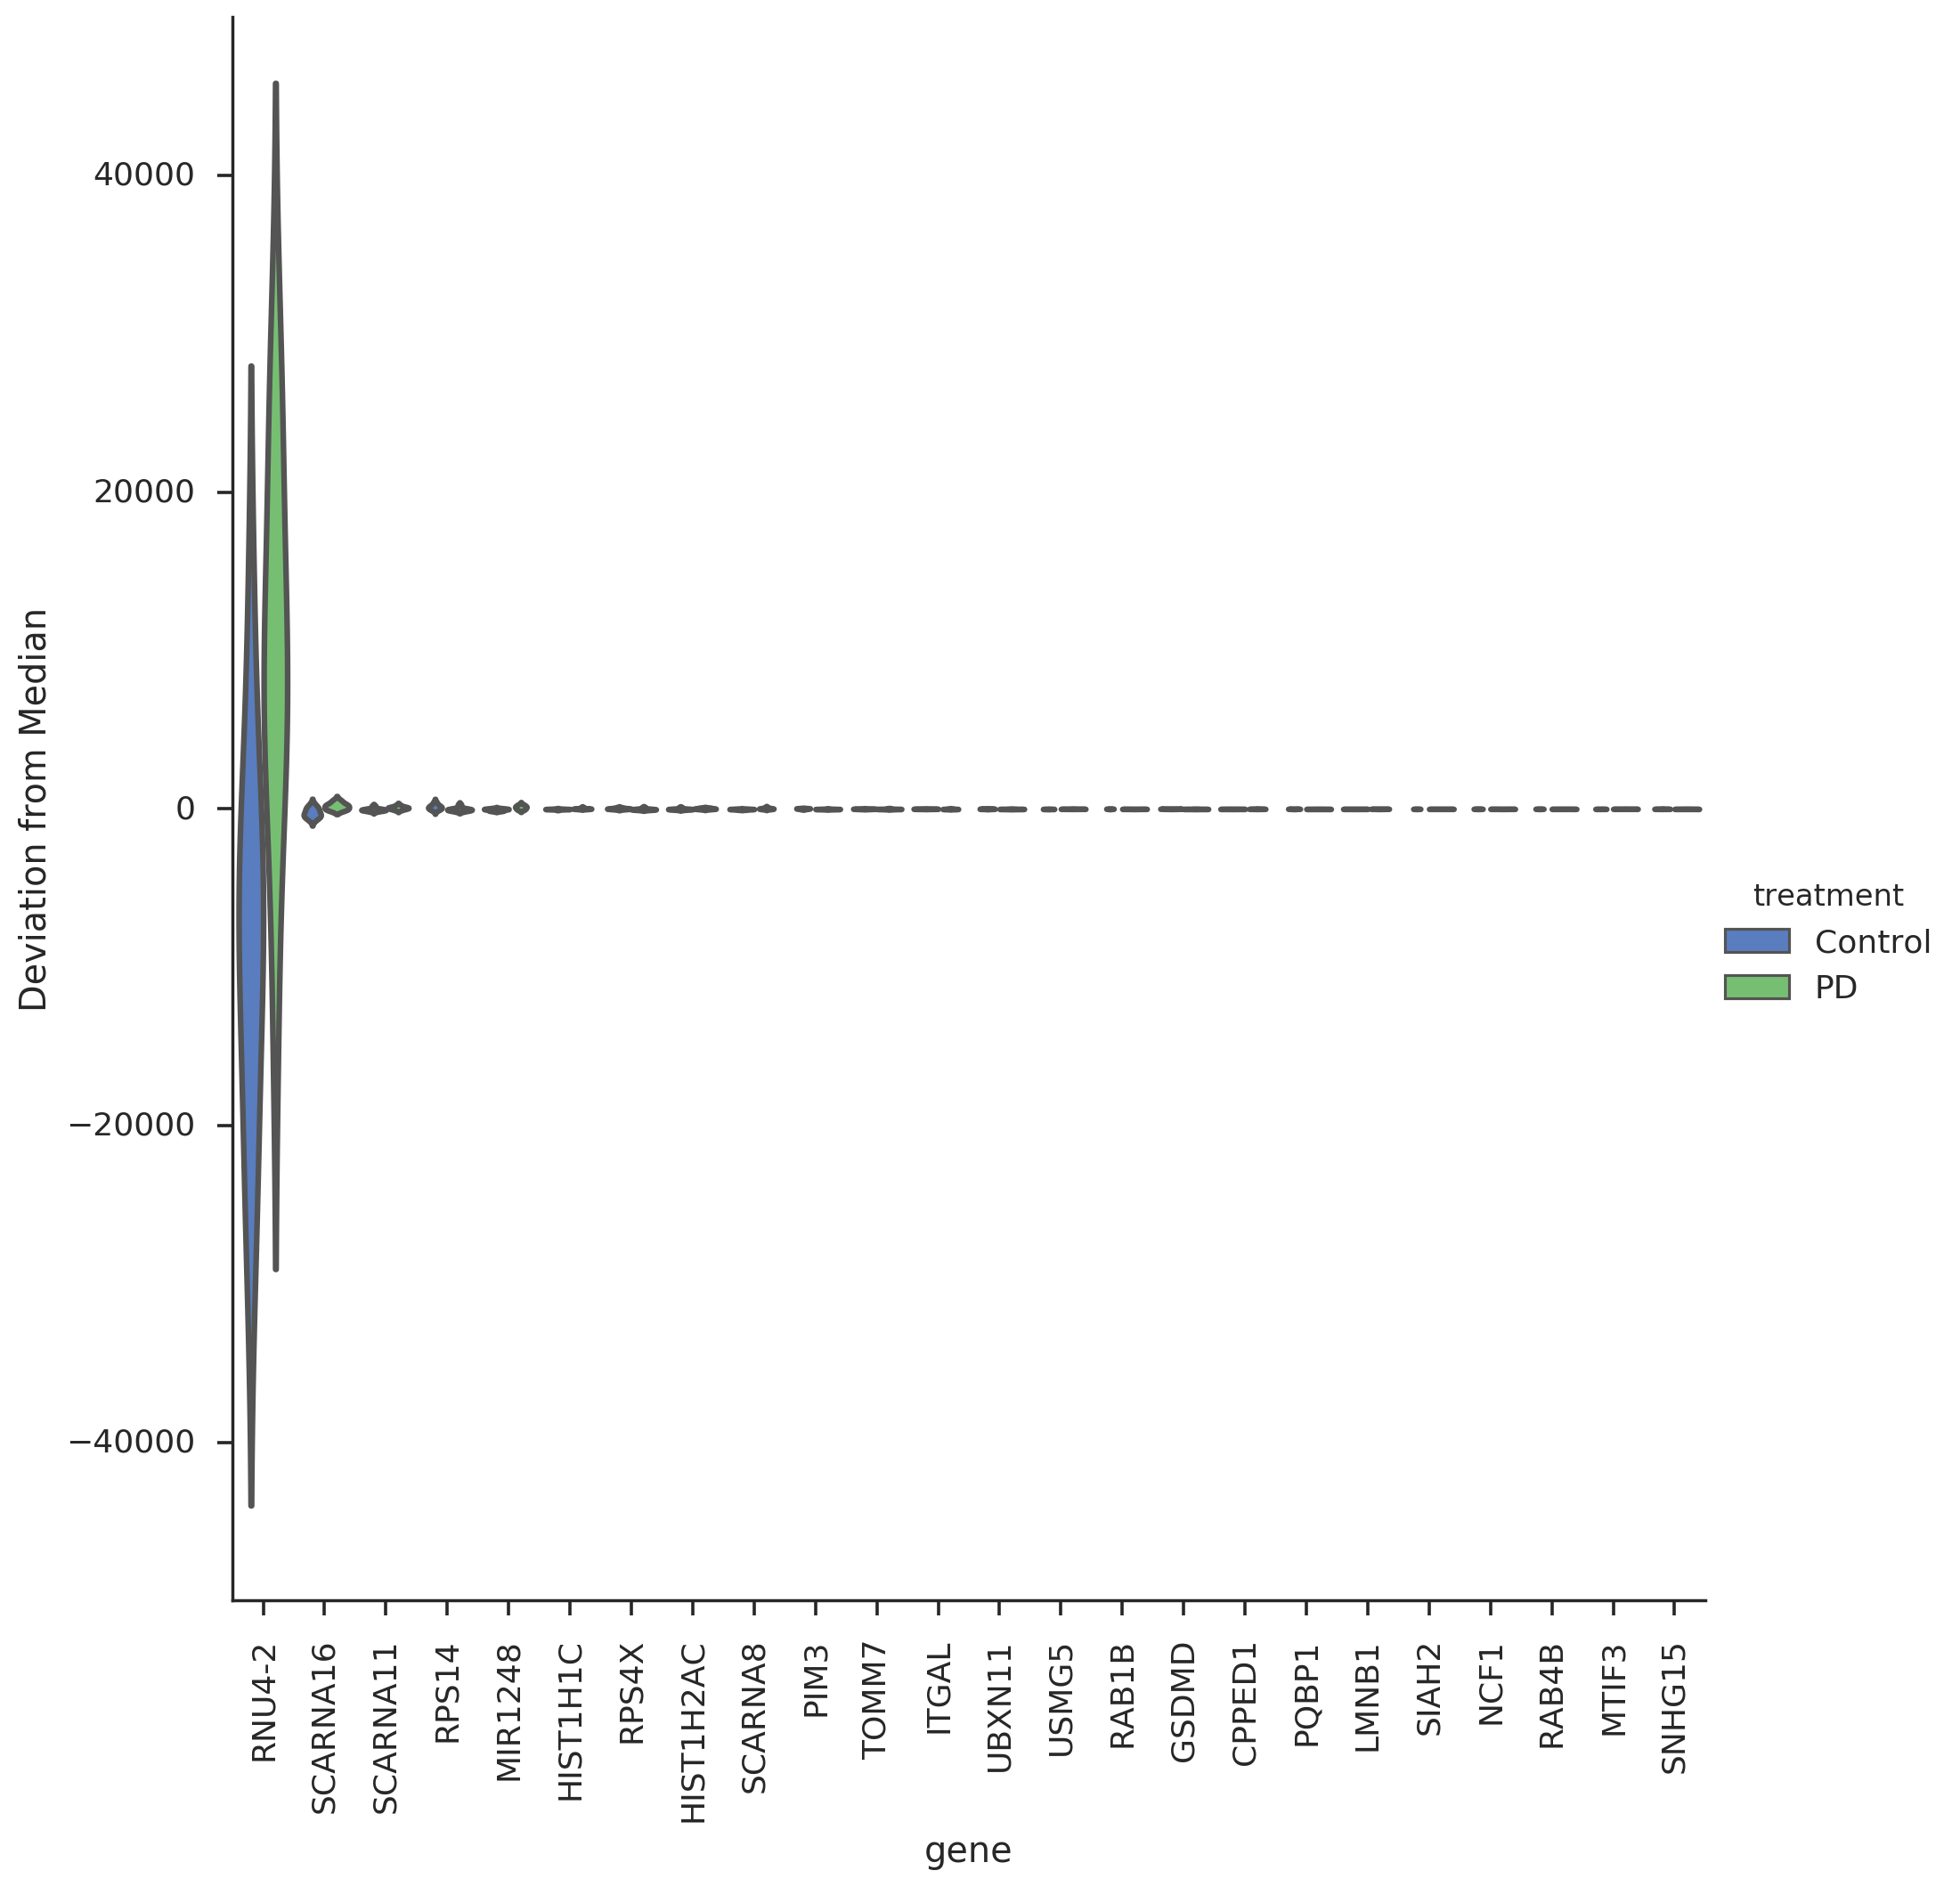

In [39]:
data = filtered_tpm_plottingFrame[filtered_tpm_plottingFrame['gene'].isin(cv_genes)]

data = data[~data['gene'].str.contains('SNOR')]
data = data[data['median tpm'] >= 10]
# data['log tpm'] = np.log2(data['tpm'] + 1)
data['Deviation from Median'] = data['tpm'] - data['median tpm']
data['Log Deviation from Median'] = [np.log2(x+1) if x > 0 else -1*np.log2(abs(x)+1) for x in data['Deviation from Median']]

data.sort('Deviation from Median', inplace=True)
sns.factorplot(data = data, 
               x='gene', 
               y = 'Deviation from Median', 
               hue='treatment', 
               kind='violin', 
               inner = None,
               size=10,
              palette='muted')
plt.xticks(rotation=90)
# plt.ylim(0,15)
plt.savefig('./figures/disregulated_genes_violinplot.pdf', bbox_inches='tight')

## Comparing EdgeR and KS Test

In [ ]:
p_threshold = 0.05
diff_expressed_genes = pval_frame[(pval_frame['median p-value'] < 0.005) & 
                                (pval_frame['variability p-value'] > 0.005) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
diff_expressed_genes = set(diff_expressed_genes)
edger_genes = set(pval_frame[pval_frame['EdgeR p-value'] < p_threshold]['Gene'].values)
matplotlib_venn.venn2([kw_genes, edger_genes], set_labels = ['Kruskal', 'EdgeR'])
plt.title('Overlap of differentially expressed genes')

In [ ]:
p_threshold = 0.01
diff_expressed_genes = pval_frame[(pval_frame['median p-value'] < 0.005) & 
                                (pval_frame['variability p-value'] > 0.005) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
# kw_genes = [x for x in kw_genes if x in idr_genes]

# edger_genes = [x for x in edger_genes if x in idr_genes]

diff_expressed_genes = set(diff_expressed_genes)
matplotlib_venn.venn2([diff_expressed_genes, set(cv_genes)], set_labels = ['Kruskal (p<'+str(p_threshold)+')', 'Cross Validation (p<0.05)'])
plt.title('Overlap of differentially expressed genes')


In [ ]:
def calc_dist_from_median(vals):
    med = np.median(vals)
    distances = [x - med for x in vals]
    return distances

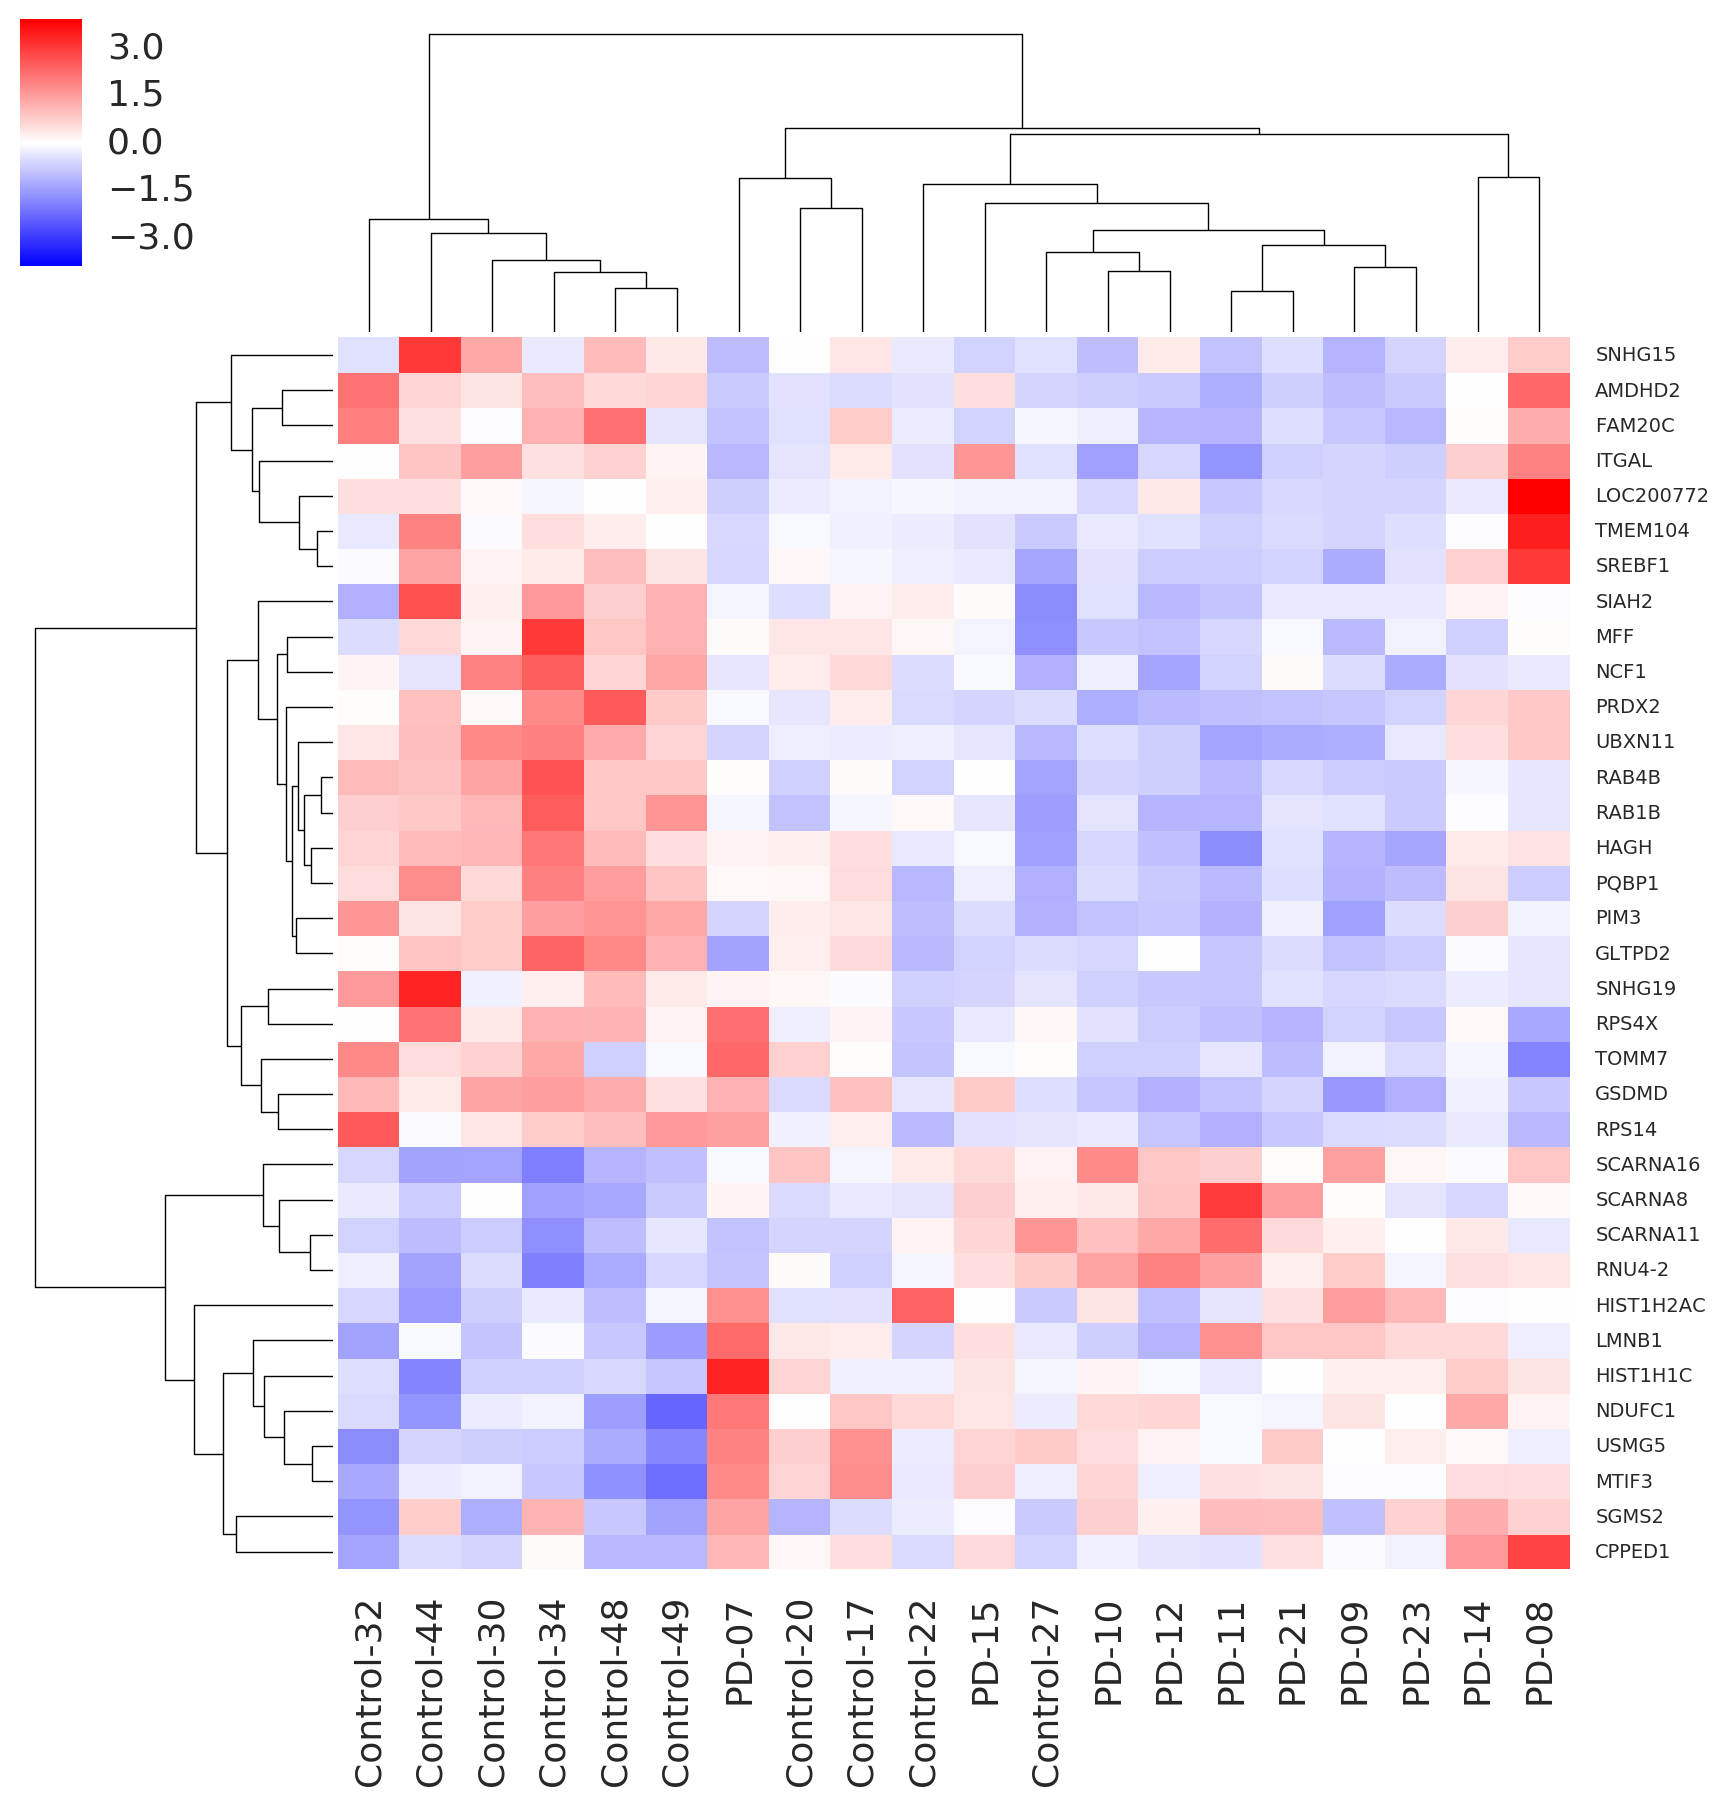

In [264]:
sns.set_style('darkgrid')
diff_expressed_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >= 4].index.values))
                               ]['Gene']

diff_expressed_genes = [x for x in diff_expressed_genes if x in cv_genes and not 'SNOR' in x and not 'MIR' in x]

features = filtered_tpm_frame[filtered_tpm_frame.index.isin(gene_list)]
features.shape
data = filtered_tpm_frame[\
                    filtered_tpm_frame.index.isin(diff_expressed_genes)]

# data.index = [refseq_gene_mapping[x] for x in data.index.values]
# data = np.log2(data+1)
# data = data.apply(calc_dist_from_median, axis=1)

cg = sns.clustermap(data = data,
                    cmap='bwr',
                    col_cluster=True,
                    z_score=0,
                    metric = 'correlation'
#                     vmin=-5,
#                     vmax=5
                    );
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=7);

plt.savefig('./figures/genes_heatmap.pdf', bbox_inches='tight')

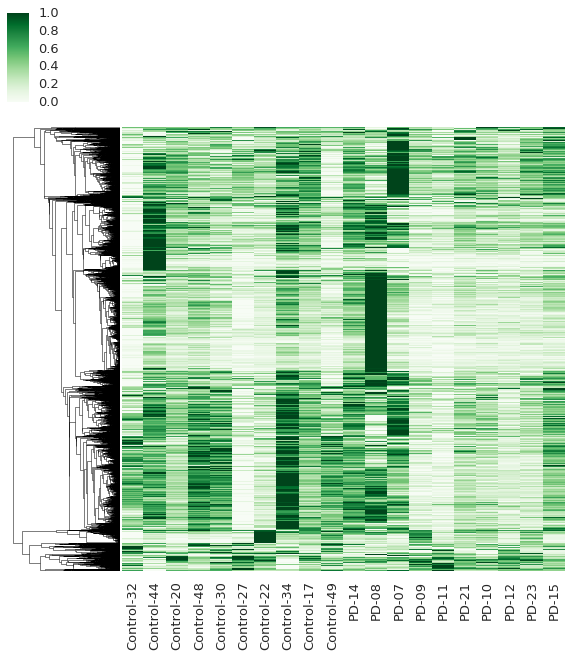

In [196]:
sns.set_style('darkgrid')

data = filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >= 10]

cg = sns.clustermap(data = data,
                    cmap='Greens',
                    col_cluster=False,
                    standard_scale=0,
                    metric = 'correlation',
                    yticklabels=False,
#                     col_colors = ['red' if 'PD' in x else 'blue' for x in data.columns.values],
                    vmin=0,
                    vmax=1,
                    
                    );
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=7);

plt.savefig('./figures/all_genes_heatmap.pdf', bbox_inches='tight')

## Stratify Variation

In [121]:
gene_size_dict = dict(zip(tpm_frame['gene'].values, (tpm_frame['end'].values - tpm_frame['start'].values)))

In [175]:
control_cols = [x for x in filtered_tpm_frame.columns if 'Control' in x]
pd_cols = [x for x in filtered_tpm_frame.columns if 'PD' in x]

control_mads = filtered_tpm_frame[control_cols].mad(axis=1)
pd_mads = filtered_tpm_frame[pd_cols].mad(axis=1)

control_medians = filtered_tpm_frame[control_cols].median(axis=1)
pd_medians = filtered_tpm_frame[pd_cols].median(axis=1)
medians=filtered_tpm_frame.median(axis=1)
control_scaled_mads = control_mads/control_medians
pd_scaled_mads = pd_mads/pd_medians


gene_sizes = np.array([gene_size_dict[x] for x in filtered_tpm_frame.index.values])

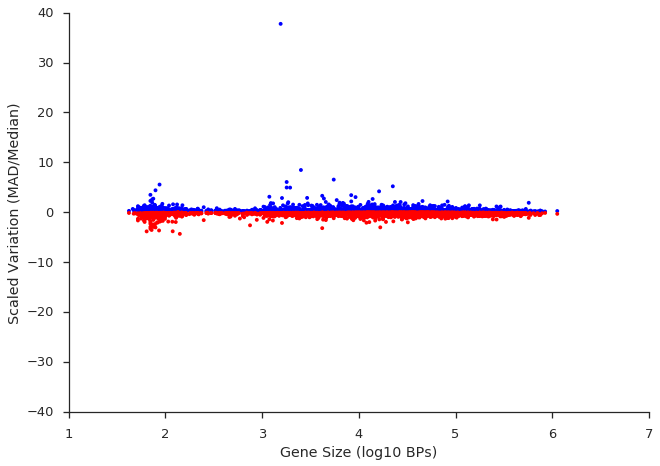

In [195]:
with sns.axes_style('ticks'):    
    
    filtered_control_vals = [x for x in zip(control_medians, control_scaled_mads, gene_sizes) if x[0]>=threshold]
    filtered_control_sizes = np.array([x[2] for x in filtered_control_vals])
    filtered_control_scaled_mads = np.array([x[1] for x in filtered_control_vals] )
    
    filtered_pd_vals = [x for x in zip(pd_medians, pd_scaled_mads, gene_sizes) if x[0]>=threshold]
    filtered_pd_sizes = np.array([x[2] for x in filtered_pd_vals])
    filtered_pd_scaled_mads = np.array([x[1] for x in filtered_pd_vals])

    
    plt.scatter(np.log10(filtered_control_sizes), filtered_control_scaled_mads , edgecolor='None', s=15, c='blue')
    plt.scatter(np.log10(filtered_pd_sizes), -filtered_pd_scaled_mads, edgecolor='None', s=15, c='red')
    plt.xlabel('Gene Size (log10 BPs)')
    plt.ylabel('Scaled Variation (MAD/Median)')
    sns.despine()
    plt.ylim(-40,40)
    plt.xlim(1,7)
    plt.savefig('./figures/size_vs_scaledVariation.pdf', bbox_inches='tight', dpi=200)

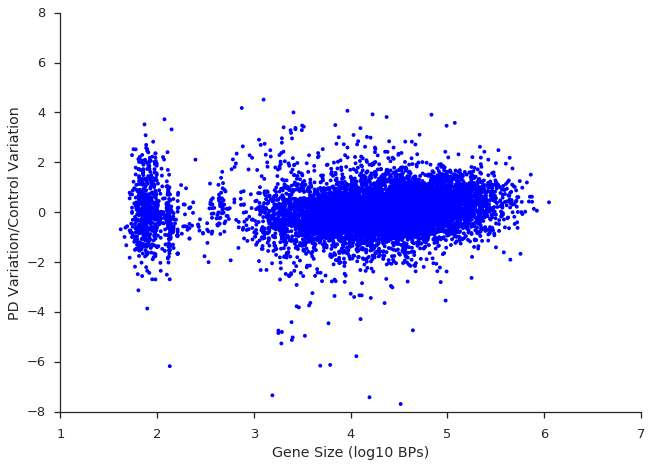

In [183]:
with sns.axes_style('ticks'):    
    plt.scatter(np.log10(gene_sizes), np.log2(pd_mads/control_mads) , edgecolor='None', s=15, c='blue')
#     plt.scatter(np.log10(gene_sizes), pd_scaled_mads, edgecolor='None', s=15, c='red')
    plt.xlabel('Gene Size (log10 BPs)')
    plt.ylabel('PD Variation/Control Variation')
    sns.despine()
    plt.ylim(-8,8)
#     plt.xlim(0,7)



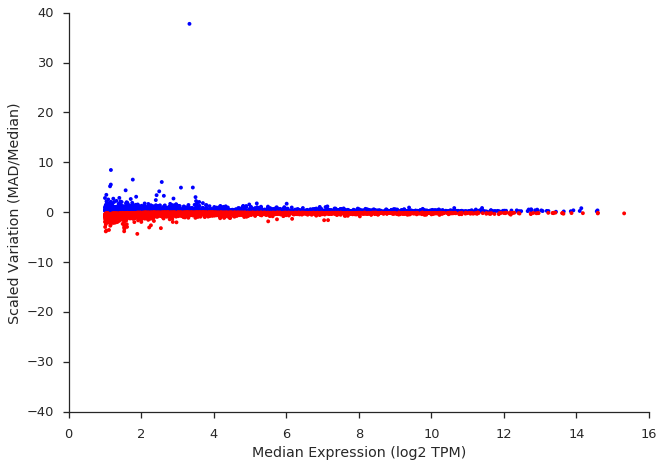

In [193]:
threshold = 1
with sns.axes_style('ticks'): 
    filtered_control_vals = [x for x in zip(control_medians, control_scaled_mads) if x[0]>=threshold]
    filtered_control_medians = np.array([x[0] for x in filtered_control_vals])
    filtered_control_scaled_mads = np.array([x[1] for x in filtered_control_vals] )
    plt.scatter(np.log2(filtered_control_medians+1), 
                filtered_control_scaled_mads, 
                edgecolor='None', s=15, c='blue')
    
    filtered_pd_vals = [x for x in zip(pd_medians, pd_scaled_mads) if x[0]>=threshold]
    filtered_pd_medians = np.array([x[0] for x in filtered_pd_vals])
    filtered_pd_scaled_mads = np.array([x[1] for x in filtered_pd_vals])
    plt.scatter(np.log2(filtered_pd_medians+1), 
                -filtered_pd_scaled_mads, 
                edgecolor='None', s=15, c='red')
    plt.xlabel('Median Expression (log2 TPM)')
    plt.ylabel('Scaled Variation (MAD/Median)')
    
    plt.xlim(0,16)
    plt.ylim(-40,40)
    sns.despine()
    
    plt.savefig('./figures/median_vs_scaledVariation.pdf', bbox_inches='tight', dpi=200)

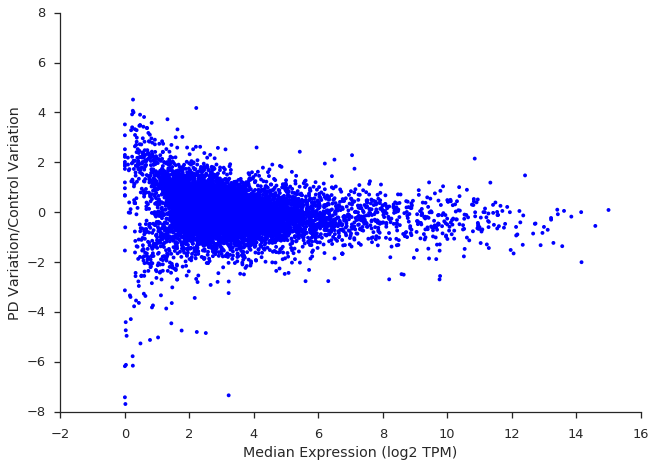

In [181]:
threshold = 1
with sns.axes_style('ticks'): 
    
    plt.scatter(np.log2(medians+1), 
                np.log2(pd_mads/control_mads), 
                edgecolor='None', s=15, c='blue')
    plt.xlabel('Median Expression (log2 TPM)')
    plt.ylabel('PD Variation/Control Variation')
    
#     plt.xlim(0,16)
    plt.ylim(-8,8)
    sns.despine()

## Regressions

In [54]:
diff_expressed_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']



In [55]:
samples = [x.split('_')[2] for x in clinical_frame.index.values]
clinical_plottingFrame = filtered_tpm_plottingFrame.copy()
clinical_atributes = ['Age',
               'Disease duration', 'H&Y (modified)', 'UPDRS-III', 'LEDD', 'TNFalpha',
               'IL-2R', 'IL-6', 'IL-8', 'IL-10', 'Leukocytes', 'Granulocytes absolut',
               'Granulozytes in %', 'Lymphocytes absolut', 'Lymphozytes in %',
               'Monocytes absolut', 'Monocytes in %', 'CRP']
for col in clinical_atributes:
    print(col)
    current_dict = dict(zip(samples,clinical_frame[col]))
    clinical_plottingFrame[col] = [current_dict[x] for x in clinical_plottingFrame['simplifiedName']]



Age
Disease duration
H&Y (modified)
UPDRS-III
LEDD
TNFalpha
IL-2R
IL-6
IL-8
IL-10
Leukocytes
Granulocytes absolut
Granulozytes in %
Lymphocytes absolut
Lymphozytes in %
Monocytes absolut
Monocytes in %
CRP


In [56]:
# samples = [x.split('_')[2] for x in clinical_frame.index.values]
# simplifiedName_age_dict = dict(zip(samples,clinical_frame['Age']))
# simplifiedName_duration_dict = dict(zip(samples,clinical_frame['Disease duration']))
# simplifiedName_UPDRS_dict = dict(zip(samples,clinical_frame['UPDRS-III']))

In [57]:
# clinical_plottingFrame = filtered_tpm_plottingFrame.copy()

# clinical_plottingFrame['age'] = [simplifiedName_age_dict[x] for x in clinical_plottingFrame['simplifiedName']]
# clinical_plottingFrame['duration'] = [simplifiedName_duration_dict[x] for x in clinical_plottingFrame['simplifiedName']]
# clinical_plottingFrame['updrs'] = [simplifiedName_UPDRS_dict[x] for x in clinical_plottingFrame['simplifiedName']]

### Down regulated

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


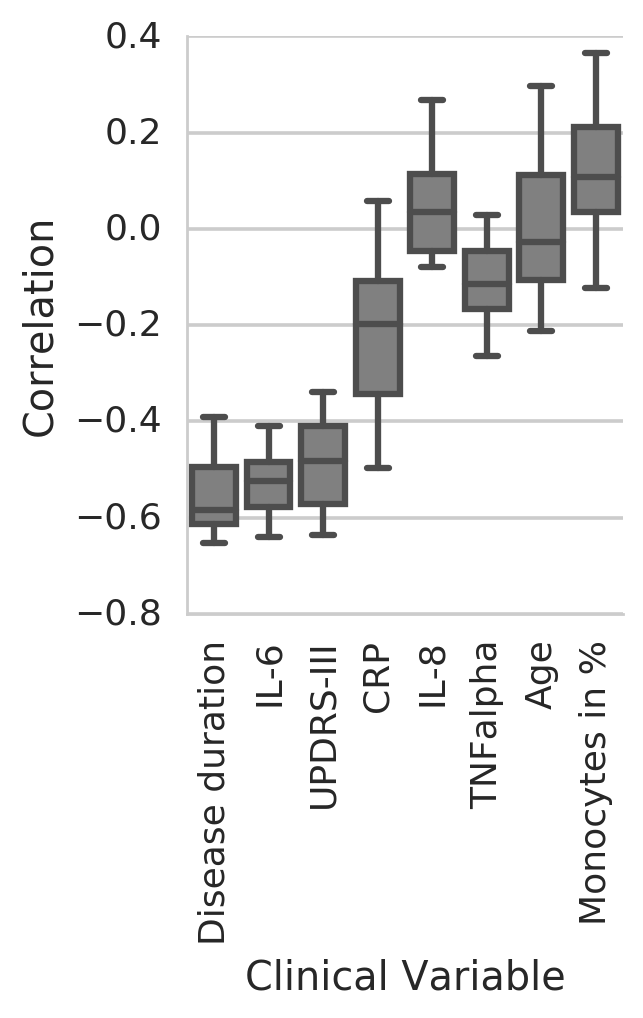

In [260]:
clinical_vars = []
coefficient_types = []
coefficients = []

gene_list = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Up or Down'] == 'down') &              
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
gene_list = [x for x in gene_list if x in cv_genes and not 'SNOR' in x and not 'MIR' in x]
genes = []
clinical_atributes = ['Age',
               'Disease duration', 'H&Y (modified)', 'UPDRS-III', 'LEDD', 'TNFalpha',
               'IL-2R', 'IL-6', 'IL-8', 'IL-10', 'Leukocytes', 'Granulocytes absolut',
               'Granulozytes in %', 'Lymphocytes absolut', 'Lymphozytes in %',
               'Monocytes absolut', 'Monocytes in %', 'CRP']
for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
    currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
    tpms = currentVals['tpm'].values
    for attribute in clinical_atributes:
        attribute_vals = currentVals[attribute].values
        r_pearson,p_pearson = stats.pearsonr(tpms, attribute_vals)
        r_spearman,p_spearman = stats.spearmanr(tpms, attribute_vals)
    
        coefficients.append(r_pearson)
        coefficient_types.append('Pearson')
        coefficients.append(r_spearman)
        coefficient_types.append('Spearman')
        clinical_vars = clinical_vars + 2*[attribute]
        genes = genes + 2 * [gene]

correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients,
                                 'Gene':genes})
correlation_frame = correlation_frame.sort('Correlation')

to_show_variables = ['Age',
               'Disease duration', 'UPDRS-III', 'TNFalpha',
               #'IL-2R', 
               'IL-6', 'IL-8', 
               #'IL-10', 'Leukocytes',
               #'Granulozytes in %',  'Lymphozytes in %',
                'Monocytes in %', 'CRP']
with sns.axes_style('whitegrid'):
    sns.factorplot(x='Clinical Variable', 
                   y='Correlation', 
    #                hue = 'Correlation Type', 
                   data = correlation_frame[(correlation_frame['Correlation Type'] == 'Spearman') &
                                            (correlation_frame['Clinical Variable'].isin(sorted(to_show_variables)))], 
                   kind='box', 
                   whis=1, 
                   showfliers=False, 
                   size=4,
                   color='Grey',
                  col_order=["Disease duration",
                            "IL-6",
                            "UPDRS-III",
                            "CRP",
                            "TNFalpha",
                             "IL-8",
                             "Age",
                             "Monocytes in %"
                            ])

    plt.xticks(rotation=90)
    plt.savefig('./figures/clinical_correlation_down.pdf', bbox_inches='tight')

### Up-regulated

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


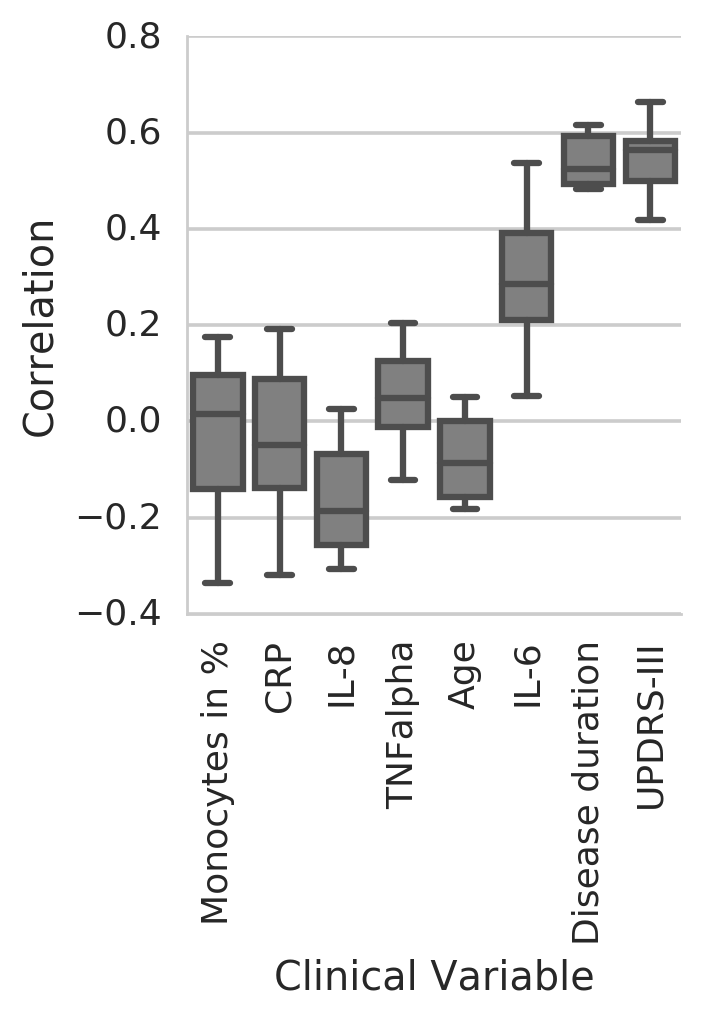

In [261]:
clinical_vars = []
coefficient_types = []
coefficients = []

gene_list = up_regulated_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Up or Down'] == 'up') &              
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
gene_list = [x for x in gene_list if x in cv_genes and not 'SNOR' in x and not 'MIR' in x]

genes = []
clinical_atributes = ['Age',
               'Disease duration', 'H&Y (modified)', 'UPDRS-III', 'LEDD', 'TNFalpha',
               'IL-2R', 'IL-6', 'IL-8', 'IL-10', 'Leukocytes', 'Granulocytes absolut',
               'Granulozytes in %', 'Lymphocytes absolut', 'Lymphozytes in %',
               'Monocytes absolut', 'Monocytes in %', 'CRP']
for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
    currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
    tpms = currentVals['tpm'].values
    for attribute in clinical_atributes:
        attribute_vals = currentVals[attribute].values
        r_pearson,p_pearson = stats.pearsonr(tpms, attribute_vals)
        r_spearman,p_spearman = stats.spearmanr(tpms, attribute_vals)
    
        coefficients.append(r_pearson)
        coefficient_types.append('Pearson')
        coefficients.append(r_spearman)
        coefficient_types.append('Spearman')
        clinical_vars = clinical_vars + 2*[attribute]
        genes = genes + 2 * [gene]

correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients,
                                 'Gene':genes})
correlation_frame = correlation_frame.sort('Correlation')


to_show_variables = ['Age',
               'Disease duration', 'UPDRS-III', 'TNFalpha',
               #'IL-2R', 
               'IL-6', 'IL-8', 
               #'IL-10', 'Leukocytes',
               #'Granulozytes in %',  'Lymphozytes in %',
                'Monocytes in %', 'CRP']
with sns.axes_style('whitegrid'):
    sns.factorplot(x='Clinical Variable', 
                   y='Correlation', 
    #                hue = 'Correlation Type', 
                   data = correlation_frame[(correlation_frame['Correlation Type'] == 'Spearman') &
                                            (correlation_frame['Clinical Variable'].isin(sorted(to_show_variables)))], 
                   kind='box', 
                   whis=1, 
                   showfliers=False, 
                   size=4,
                   color='Grey')

    plt.xticks(rotation=90)
    plt.savefig('./figures/clinical_correlation_up.pdf', bbox_inches='tight')

## PCA Analysis

In [262]:
gene_list = down_regulated_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >1].index.values))
                               ]['Gene']


gene_list = [x for x in gene_list if x in cv_genes and not 'SNOR' in x and not 'MIR' in x]

features = filtered_tpm_frame[filtered_tpm_frame.index.isin(gene_list)]
features.shape

(35, 20)

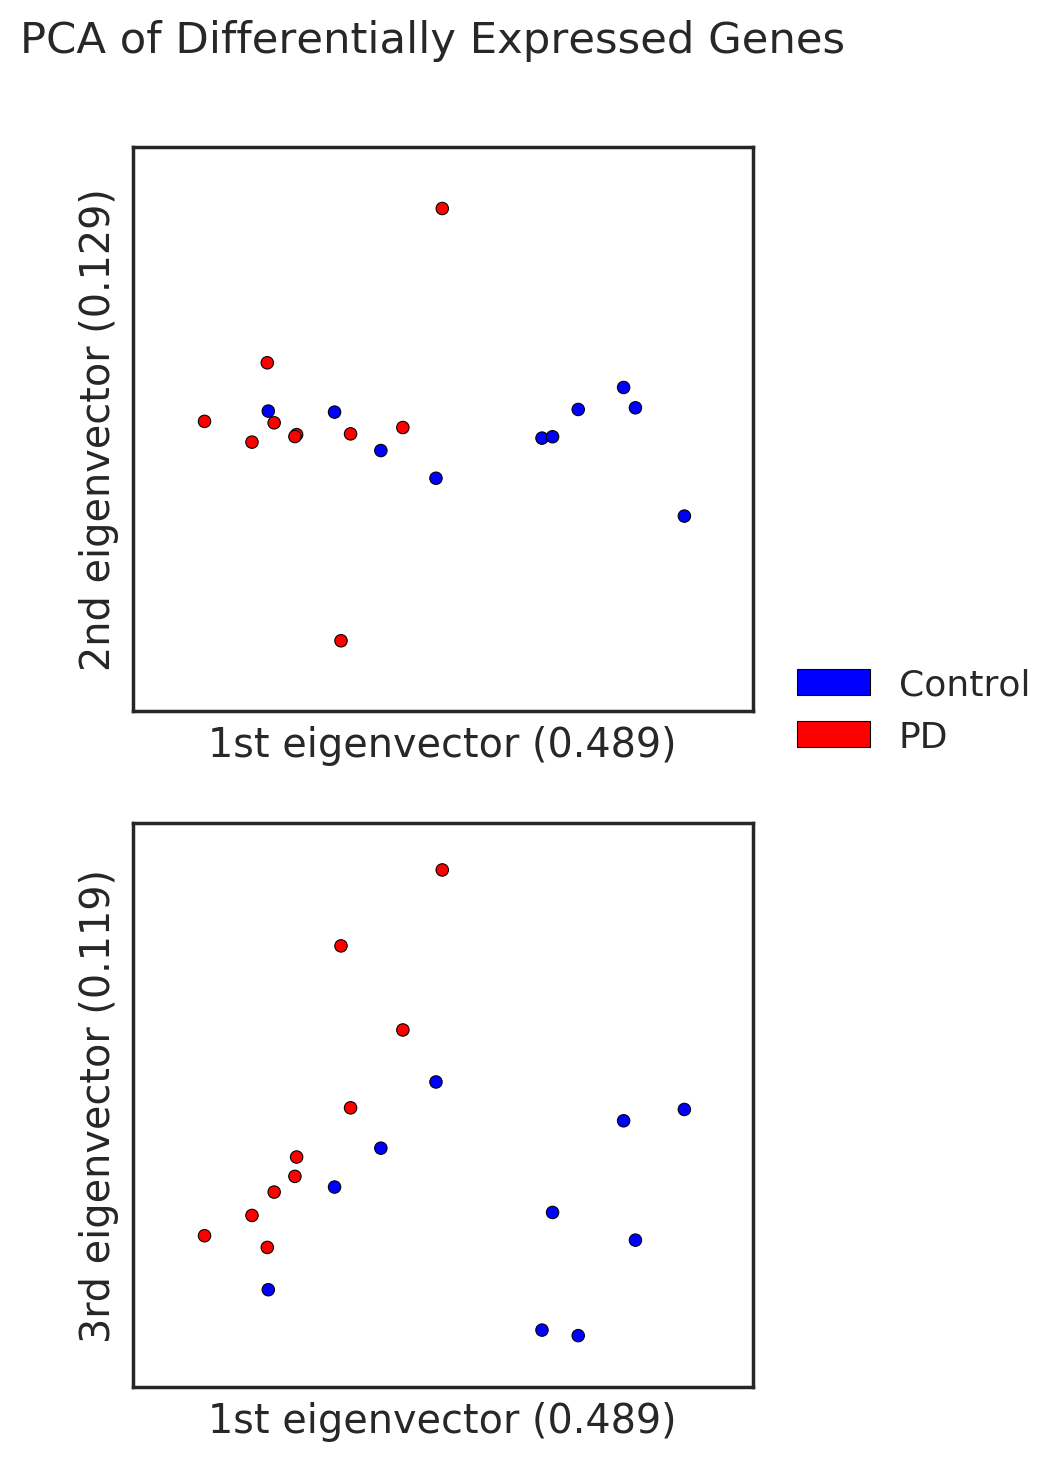

In [263]:
# standardize features
scaler = sklearn.preprocessing.StandardScaler()
standardized_features = pd.DataFrame(scaler.fit_transform(features.T))
colors = ['red' if 'PD' in x else 'blue' for x in features.columns.values]


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(features.T)
reduced_features = model.fit_transform(standardized_features)
explained_variance_ratios = model.explained_variance_ratio_

sns.set_style('white')
f, axs = plt.subplots(2,1, figsize=(4,8))
                
plt.suptitle('PCA of Differentially Expressed Genes')

# 1st and 2nd principal component
plt.subplot(2,1,1)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# legend
classes = sorted(set(filtered_summary_frame['simpleTreatment'].values))
class_colours = ['blue', 'red']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 0))

# 1st and 3rd principal component
plt.subplot(2,1,2)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])

plt.savefig('./figures/pca_2d_diffExpressed.pdf', bbox_inches='tight')
plt.show()

## Gene Ontology Analysis

### Print Genes for Metascape

#### Disregulated

In [ ]:
disregulated_genes = pval_frame[(pval_frame['median p-value'] > 0.01) & 
                                (pval_frame['variability p-value'] < 0.01) &
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
for gene in disregulated_genes:
    print(gene)

#### Downregulated

In [ ]:
down_regulated_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Up or Down'] == 'down') &              
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
for gene in down_regulated_genes:
    print(gene)

#### Up-regulated

In [ ]:
up_regulated_genes = pval_frame[(pval_frame['median p-value'] < 0.01) & 
                                (pval_frame['variability p-value'] > 0.01) &
                                (pval_frame['Up or Down'] == 'up') &              
                                (pval_frame['Gene'].isin(filtered_tpm_frame[filtered_tpm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
for gene in up_regulated_genes:
    print(gene)

In [ ]:
p_threshold = 0.01
gene_list_up = stat_frame[(stat_frame['KW pval'] <p_threshold) & (stat_frame['Up or Down'] == 'up')]['gene'].values
gene_list_up = [x for x in gene_list_up if x in cv_genes]
gene_list_down = stat_frame[(stat_frame['KW pval'] <p_threshold) & (stat_frame['Up or Down'] == 'down')]['gene'].values
gene_list_down = [x for x in gene_list_down if x in cv_genes]

# write target genes file
outFile = open('go_genes_up.txt', 'w')
for g in gene_list_up:
    outFile.write(g.upper()+ '\n')
outFile.close()

outFile = open('go_genes_down.txt', 'w')
for g in gene_list_down:
    outFile.write(g.upper()+ '\n')
outFile.close()

# write background file
outFile = open('background.txt', 'w')
for g in [refseq_gene_mapping[x] for x in filtered_tpm_frame.index.values]:
    outFile.write(g.upper() + '\n')
outFile.close()

In [ ]:
os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./go_genes_up.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_up.txt')

os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./go_genes_down.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_down.txt')


In [ ]:
go_frame_up = pd.read_csv('go_results_up.txt',sep='\t', skiprows=2)

In [ ]:
go_frame_down = pd.read_csv('go_results_down.txt',sep='\t', skiprows=2)

In [ ]:
gene_go_dict = {}
go_gene_dict = {}
with open('/home/jenhan/analysis/go_analysis/human_association') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split('\t')
    gene = tokens[0]
    terms = tokens[1].split(';')
    gene_go_dict[gene] = terms
    for t in terms:
        if t in go_gene_dict:
            go_gene_dict[t].append(gene)
        else:
            go_gene_dict[t] = [gene]

        

In [ ]:
go_description_dict = dict(zip(go_frame_up['id'].values, go_frame_up['description'].values))
go_description_dict.update(dict(zip(go_frame_down['id'].values, go_frame_down['description'].values)))

In [ ]:
term_children_dict = {
'GO:0060563':set(['GO:0060563','GO:0061453', 'GO:0030318', 'GO:0050933', 'GO:0042491', 'GO:0050934', 'GO:0060531', 'GO:0061104', 'GO:0061102', 'GO:0061103', 'GO:0061100', 'GO:0061101', 'GO:0060129', 'GO:0071895']),
'GO:0046328':set(['GO:0046328','GO:0007256', 'GO:0046329', 'GO:0046330', 'GO:0042655', 'GO:0043508', 'GO:0007257', 'GO:0043506', 'GO:0043507']),
'GO:0030217':set(['GO:0046632', 'GO:0061470', 'GO:0002361', 'GO:0042093', 'GO:0002303', 'GO:0002302', 'GO:0002301', 'GO:0002300', 'GO:1904156', 'GO:1904157', 'GO:0001865', 'GO:0002304', 'GO:0002307', 'GO:0002308', 'GO:0043367', 'GO:0002306', 'GO:0002305', 'GO:0033077', 'GO:0033078', 'GO:1904155', 'GO:0072539', 'GO:0045066', 'GO:0045063', 'GO:0002293', 'GO:0002292', 'GO:0002294', 'GO:0045065', 'GO:0045064', 'GO:0002299', 'GO:0002298', 'GO:0042492', 'GO:0043379', 'GO:0043374']),
'GO:0042110': set(['GO:0002289', 'GO:0033080', 'GO:0046633', 'GO:0046632', 'GO:0061470', 'GO:0046630', 'GO:0042722', 'GO:0002303', 'GO:0002302', 'GO:0002301', 'GO:0002300', 'GO:1904156', 'GO:0001866', 'GO:0001865', 'GO:0002304', 'GO:0002307', 'GO:0002309', 'GO:0002308', 'GO:0043367', 'GO:1904157', 'GO:0002305', 'GO:0030217', 'GO:1904155', 'GO:0046631', 'GO:0035709', 'GO:0045063', 'GO:0045066', 'GO:0045065', 'GO:0045064', 'GO:0042492', 'GO:0043379', 'GO:0043316', 'GO:0035739', 'GO:0043374', 'GO:0046629', 'GO:0002306', 'GO:0036037', 'GO:0050798', 'GO:0042093', 'GO:0002286', 'GO:0002287', 'GO:0002288', 'GO:0042098', 'GO:0002361', 'GO:0035712', 'GO:0035741', 'GO:0035740', 'GO:0051132', 'GO:0035742', 'GO:0033077', 'GO:0033079', 'GO:0033078', 'GO:0001777', 'GO:0072539', 'GO:0002291', 'GO:0002290', 'GO:0002293', 'GO:0002292', 'GO:0002294', 'GO:0061485', 'GO:0002299', 'GO:0002298', 'GO:0002310', 'GO:0002311', 'GO:0035710', 'GO:0035711'])
                     }

In [ ]:
_genes = []
_descriptions = []

for term in term_children_dict.keys():
    genes = []
    for t in term_children_dict[term]:
        if t in go_gene_dict:
            genes = genes+ go_gene_dict[t]
    genes = sorted(set(genes))
    print('***',term, go_description_dict[term], len(genes))
    for g in genes:
        if g.upper() in cv_genes or g in cv_genes:
            print(g)
            _genes.append(g)
            _descriptions.append(go_description_dict[term])


gene_description_dict = dict(zip(_genes, _descriptions))

In [ ]:
sig_genes = _genes
go_plotting_frame = filtered_tpm_plottingFrame[filtered_tpm_plottingFrame['gene'].isin(sig_genes)]
gene_pval_dict = dict(zip(stat_frame['gene'].values, stat_frame['KW pval'].values))
go_plotting_frame['Term'] = [gene_description_dict[x] for x in go_plotting_frame['gene']]
go_plotting_frame['p-value']=[gene_pval_dict[x] for x in go_plotting_frame['gene']]
go_plotting_frame.columns = ['Gene', 'Refseq', 'tpm', 'Sample Name', 'Group', 'Term', 'p-value']

In [ ]:
! if [ ! -d ./bar_plots ]; then mkdir ./bar_plots; fi
for term in sorted(set(go_plotting_frame['Term'].values)):
    sns.factorplot(data = go_plotting_frame[go_plotting_frame['Term']==term].sort('p-value'), 
                   x='Gene', 
                   y='tpm', 
                   hue = 'Group', 
                   kind='bar',
                   hue_order = ['Control', 'PD'],
                   size=10)
    plt.title(term)
    plt.savefig('./bar_plots/'+'_'.join(term.split())+'.pdf')
    plt.show()
sns.factorplot(data = go_plotting_frame[go_plotting_frame['Gene'].isin(['NCOR1','RC3H1','ZFP36L2'])], 
              x='Gene', 
                   y='tpm', 
                   hue = 'Group', 
                   kind='bar',
                   hue_order = ['Control', 'PD'],
                   size=10)
plt.title('T cell differentiation')
plt.savefig('./bar_plots/'+'_'.join('T cell differentiation'.split())+'.pdf')



In [ ]:
data = data=go_plotting_frame

gene_foldChange_dict = dict(zip(stat_frame['gene'], stat_frame['fold change']))
data['fold change'] = [gene_foldChange_dict[x] for x in data['Gene']]

In [ ]:
sns.factorplot(x='Gene', 
               y='tpm', 
               kind='bar',
               data=data, 
               hue='Group',
              size=10)
plt.savefig('bar_plot_all.pdf')

In [ ]:
data = idr_tpm_mean_frame[idr_tpm_mean_frame.index.isin(cv_genes)]
logged_data = np.log2(data+1)
logged_data = logged_data.sort('Control')
with sns.axes_style('ticks', {'axes.grid':False, 'grid.color':'white'}):
    logged_data.plot(kind='bar', sort_columns=True)
    sns.despine()
    plt.ylabel('Log2 tpm')
    plt.xlabel('Gene Name')
plt.savefig('./figures/allGenes_barplot.pdf',bbox_inches='tight')

In [ ]:
reads1 = np.log2(idr_tpm_median_frame['Control']+1)
reads2 = np.log2(idr_tpm_median_frame['PD']+1)
names = idr_tpm_median_frame.index.values

# reads1 = np.log2(idr_tpm_mean_frame['Control']+1)
# reads2 = np.log2(idr_tpm_mean_frame['PD']+1)
# names = idr_tpm_mean_frame.index.values

tuples = zip(reads1, reads2, names)
filtered_tuples = [x for x in tuples if x[0] >=2 or x[1]>=2]

filtered_reads1 = [x[0] for x in filtered_tuples]
filtered_reads2 = [x[1] for x in filtered_tuples]

with sns.axes_style('ticks'):
    plt.scatter(filtered_reads1, filtered_reads2,
                marker = '.', s=15,
               c='blue',
               edgecolors='none', )
    for x, y, label in filtered_tuples:
        fold = x/y
    #     if fold >= 1.3 or fold <=1/1.3:
        if label in cv_genes:
            plt.annotate(label, size=10, xy=(x,y))

    ax = plt.gca()
    ax.set_xlim((0,12))
    ax.set_ylim((0,12))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    plt.xlabel('Control Log2 tpm')
    plt.ylabel('PD Log2 tpm')
    sns.despine()
    plt.savefig('./figures/scatterplot_annotated.pdf',bbox_inches='tight')